In [534]:
import pandas as pd
from torch import tensor
import numpy as np

In [ ]:
pd.set_option('display.max_rows', 10)

In [ ]:
sorted_data = pd.read_hdf('code/data.h5', 'sorted_with_aggs')
sorted_data

In [ ]:
data = sorted_data[(sorted_data['QUOTE_DATE'] > '2011-01-01') & (sorted_data['QUOTE_DATE'] < '2012-01-01')]

data

In [ ]:
from pytorch_forecasting import TimeSeriesDataSet, GroupNormalizer

In [ ]:
from pandas_market_calendars import get_calendar_names

get_calendar_names()

In [ ]:
from pandas_market_calendars import get_calendar
holidays = list(get_calendar('CBOE_Index_Options').holidays().holidays)
holidays

In [ ]:
min_quote_date = data['QUOTE_DATE'].min().date()
def compute_time_idx(row):
    return np.busday_count(min_quote_date, row['QUOTE_DATE'].date(), holidays=holidays)
data['TIME_IDX'] = data.apply(compute_time_idx, axis=1)
data

In [ ]:
len(set(data['TIME_IDX']))

In [ ]:
data.columns

In [ ]:
from numbers import Number
isinstance(1, Number)

In [ ]:
data = data.dropna(subset=['C_LAST'])

In [ ]:
d = {
    'TIME_IDX': np.arange(0, 10, 1), 
    'C_LAST': np.arange(1, 2, 0.1),
    'EXPIRE_UNIX': np.ones(10) * 2,
    'STRIKE': np.ones(10) * 3,
    'UNDERLYING_LAST': np.random.rand(10) * 100
    }
df = pd.DataFrame(d)
df

In [ ]:
dataset = TimeSeriesDataSet(
    data,
    time_idx='TIME_IDX',
    target='C_LAST',
    group_ids=['EXPIRE_UNIX', 'STRIKE'],
    max_encoder_length=5,
    max_prediction_length=1,
    # add_relative_time_idx=True,
    static_reals=[],
    time_varying_known_reals=[],
    time_varying_unknown_reals=['UNDERLYING_LAST'],
    allow_missing_timesteps=True,
)

loader = dataset.to_dataloader(train=False, batch_size=1, num_workers=0)
x, y = next(iter(loader))

for i in x:
    print(i)
    print(x[i].numpy())
    print(x[i].size())

In [ ]:
from torch import Dataset

class LSTMDataset(Dataset):
    

In [ ]:
grouped = data.groupby(by=['STRIKE', 'EXPIRE_DATE'])
iterator = iter(grouped)


In [ ]:
grouped.size()

In [ ]:
next(iterator)

In [ ]:
grouped.get_group(list(grouped.groups.keys())[2])[10:]

In [ ]:
grouped.size().apply(lambda x: x - 100 if x > 100 else 0)

In [ ]:
grouped.size().apply(lambda x: x - 100 if x > 100 else 0).sum()

In [ ]:
(x['encoder_cont'] + 191.59676 )* 89.70744 

In [ ]:
x['decoder_cont'] * 0.2882047 + 1.45

In [ ]:
y

In [561]:
underlying = data[['QUOTE_DATE', 'UNDERLYING_LAST']]

In [564]:
underlying

,QUOTE_DATE,UNDERLYING_LAST
0,2011-01-03,1271.36
1,2011-01-04,1270.37
2,2011-01-05,1276.47
3,2011-01-06,1273.88
4,2011-01-07,1271.60
...,...,...
240,2011-12-23,1265.21
241,2011-12-27,1265.60
242,2011-12-28,1249.37
243,2011-12-29,1261.92


In [563]:
underlying = underlying.groupby('QUOTE_DATE').first().reset_index()

In [ ]:
underlying['idx'] = underlying.apply(compute_time_idx, axis=1)

In [ ]:
pd.set_option('display.max_rows', None)
underlying

In [512]:
def create_empty_rows(df: pd.DataFrame, idx: str, date_key: str = None) -> pd.DataFrame:
    min_idx = df[idx].min()
    max_idx = df[idx].max()

    df = df.set_index(idx).reindex(range(min_idx, max_idx + 1))
    if date_key:
        min_date = df[date_key].min()
        max_date = df[date_key].max()
        df[date_key] = pd.bdate_range(start=min_date, end=max_date, freq='C', holidays=holidays)
    return df

def fill_missing_values(df: pd.DataFrame, idx: str, date_key: str = None) -> pd.DataFrame:
    df = create_empty_rows(df, idx, date_key)
    return df.interpolate('linear')


In [ ]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
#df['UNDERLYING_LAST'] = imp.fit_transform(df)
fill_missing_values(underlying, 'idx')

In [ ]:
daily_yields = pd.read_csv('daily-treasury-rates.csv')

In [535]:
data.iloc[0]['QUOTE_DATE']

Timestamp('2011-01-03 00:00:00')

In [481]:
pd.set_option('display.max_rows', 10)
daily_yields

,Date,1 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
0,12/30/2011,0.01,0.02,0.06,0.12,0.25,0.36,0.83,1.35,1.89,2.57,2.89
1,12/29/2011,0.00,0.02,0.07,0.12,0.28,0.41,0.88,1.38,1.91,2.58,2.90
2,12/28/2011,0.00,0.01,0.05,0.12,0.28,0.42,0.91,1.41,1.93,2.59,2.91
3,12/27/2011,0.01,0.02,0.06,0.12,0.30,0.45,0.96,1.49,2.02,2.72,3.04
4,12/23/2011,0.00,0.01,0.04,0.12,0.28,0.45,0.97,1.49,2.03,2.73,3.05
...,...,...,...,...,...,...,...,...,...,...,...,...
245,01/07/2011,0.13,0.14,0.18,0.29,0.60,1.02,1.96,2.69,3.34,4.25,4.48
246,01/06/2011,0.13,0.15,0.18,0.30,0.68,1.11,2.09,2.80,3.44,4.31,4.53
247,01/05/2011,0.13,0.14,0.19,0.31,0.71,1.16,2.14,2.86,3.50,4.34,4.55
248,01/04/2011,0.12,0.14,0.19,0.28,0.63,1.04,2.01,2.72,3.36,4.21,4.44


In [485]:
def compute_time_idx_yields(row):
    return np.busday_count(min_quote_date, pd.to_datetime(row['Date']).date(), holidays=holidays)

In [487]:
daily_yields['idx'] = daily_yields.apply(compute_time_idx_yields, axis=1)
daily_yields

,Date,1 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr,idx
0,12/30/2011,0.01,0.02,0.06,0.12,0.25,0.36,0.83,1.35,1.89,2.57,2.89,251
1,12/29/2011,0.00,0.02,0.07,0.12,0.28,0.41,0.88,1.38,1.91,2.58,2.90,250
2,12/28/2011,0.00,0.01,0.05,0.12,0.28,0.42,0.91,1.41,1.93,2.59,2.91,249
3,12/27/2011,0.01,0.02,0.06,0.12,0.30,0.45,0.96,1.49,2.02,2.72,3.04,248
4,12/23/2011,0.00,0.01,0.04,0.12,0.28,0.45,0.97,1.49,2.03,2.73,3.05,247
...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,01/07/2011,0.13,0.14,0.18,0.29,0.60,1.02,1.96,2.69,3.34,4.25,4.48,4
246,01/06/2011,0.13,0.15,0.18,0.30,0.68,1.11,2.09,2.80,3.44,4.31,4.53,3
247,01/05/2011,0.13,0.14,0.19,0.31,0.71,1.16,2.14,2.86,3.50,4.34,4.55,2
248,01/04/2011,0.12,0.14,0.19,0.28,0.63,1.04,2.01,2.72,3.36,4.21,4.44,1


In [500]:
daily_yields['Date'] = pd.to_datetime(daily_yields['Date'])

In [513]:
pd.set_option('display.max_rows', 10)
ylds = fill_missing_values(daily_yields, 'idx', 'Date')

In [516]:
pd.set_option('display.max_rows', 10)
ylds

,Date,1 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
idx,,,,,,,,,,,,
0,2011-01-03,0.11,0.15,0.19,0.29,0.61,1.03,2.02,2.74,3.36,4.18,4.39
1,2011-01-04,0.12,0.14,0.19,0.28,0.63,1.04,2.01,2.72,3.36,4.21,4.44
2,2011-01-05,0.13,0.14,0.19,0.31,0.71,1.16,2.14,2.86,3.50,4.34,4.55
3,2011-01-06,0.13,0.15,0.18,0.30,0.68,1.11,2.09,2.80,3.44,4.31,4.53
4,2011-01-07,0.13,0.14,0.18,0.29,0.60,1.02,1.96,2.69,3.34,4.25,4.48
...,...,...,...,...,...,...,...,...,...,...,...,...
247,2011-12-23,0.00,0.01,0.04,0.12,0.28,0.45,0.97,1.49,2.03,2.73,3.05
248,2011-12-27,0.01,0.02,0.06,0.12,0.30,0.45,0.96,1.49,2.02,2.72,3.04
249,2011-12-28,0.00,0.01,0.05,0.12,0.28,0.42,0.91,1.41,1.93,2.59,2.91


In [ ]:

sample_yields = daily_yields[pd.to_datetime(daily_yields['Date']) == data.iloc[0]['QUOTE_DATE']]
sample_yields

In [ ]:
from nelson_siegel_svensson.calibrate import calibrate_nss_ols 

maturities = np.array([1/12, 3/12, 0.5, 1, 2, 3, 5, 7, 10, 20, 30])
values = sample_yields.loc[:,sample_yields.columns != 'Date'].to_numpy().squeeze()
# print(values.shape, maturities.shape)
curve, status = calibrate_nss_ols(maturities, values, tau0=(1, 1))
# assert status.success
print(curve)

In [ ]:
from matplotlib import pyplot as plt

y = np.array([curve(x) for x in maturities])
plt.plot(maturities, y)
y

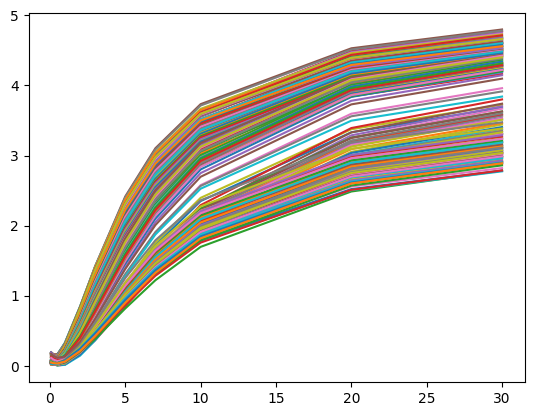

{'2011-01-03': NelsonSiegelCurve(beta0=5.004965443401459, beta1=-4.816269986229901, beta2=-5.718290321167789, tau=1.6069988899342291),
 '2011-01-04': NelsonSiegelCurve(beta0=5.064258028247596, beta1=-4.885186401432757, beta2=-5.670189506431316, tau=1.6571271810822163),
 '2011-01-05': NelsonSiegelCurve(beta0=5.16627006941595, beta1=-4.993207518273713, beta2=-5.648420732212464, tau=1.6055159325030515),
 '2011-01-06': NelsonSiegelCurve(beta0=5.156212263000688, beta1=-4.979397784759868, beta2=-5.670599034710259, tau=1.6439146792951171),
 '2011-01-07': NelsonSiegelCurve(beta0=5.139115931516336, beta1=-4.957624463438536, beta2=-5.734686501047819, tau=1.7217089620185229),
 '2011-01-10': NelsonSiegelCurve(beta0=5.136673463153119, beta1=-4.944133569424452, beta2=-5.76893056343216, tau=1.7439293927380046),
 '2011-01-11': NelsonSiegelCurve(beta0=5.14239726621609, beta1=-4.939446279505681, beta2=-5.852576807015108, tau=1.6877541421094766),
 '2011-01-12': NelsonSiegelCurve(beta0=5.171499121004221, 

In [526]:
from nelson_siegel_svensson.calibrate import calibrate_ns_ols
yield_curves = {}

for index, row in ylds.iterrows():
    # print(pd.to_datetime(row['Date']).strftime('%Y-%m-%d'))
    # print(row.values[1:])
    values = row[1:].to_numpy(dtype=np.float64)
    curve, status = calibrate_ns_ols(maturities, values)
    assert status.success
    yield_curves[row['Date'].strftime('%Y-%m-%d')] = curve
    plt.plot(maturities, np.array([curve(x) for x in maturities]))

plt.show()
yield_curves

In [533]:
crv, sts = calibrate_ns_ols(maturities, np.array([0.01, 0.02, 0.04, 0.1,  0.27, 0.4,  0.88, 1.41, 1.96, 2.66, 2.98]))
[crv(x) for x in maturities]
crv(0)

0.043793900807628905

In [530]:
def compute_rfr(row):
    date = row['QUOTE_DATE'].strftime('%Y-%m-%d')
    return yield_curves[date](row['TTM'])

data['RISK_FREE_RATE'] = data.apply(compute_rfr, axis=1)
data[data['RISK_FREE_RATE'].max() == data['RISK_FREE_RATE']]

# def compute_time_idx(row):
#     return np.busday_count(min_quote_date, row['QUOTE_DATE'].date(), holidays=holidays)
# data['TIME_IDX'] = data.apply(compute_time_idx, axis=1)

/var/folders/4h/wb36ylt17sj6v882tp7lx6140000gn/T/ipykernel_21501/2652344877.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['RISK_FREE_RATE'] = data.apply(compute_rfr, axis=1)


,QUOTE_UNIXTIME,QUOTE_READTIME,QUOTE_DATE,QUOTE_TIME_HOURS,UNDERLYING_LAST,EXPIRE_DATE,EXPIRE_UNIX,DTE,C_DELTA,C_GAMMA,...,P_THETA,P_RHO,P_IV,P_VOLUME,STRIKE_DISTANCE,STRIKE_DISTANCE_PCT,TTM,Moneyness,TIME_IDX,RISK_FREE_RATE
253249,1297198800,2011-02-08 16:00:00,2011-02-08,16.0,1324.46,2013-12-19,1387486800,1045.0,0.45261,0.00098,...,-0.08528,-26.64552,0.16607,NaN,75.5,0.057,2.863014,1.057035,25,1.340698
253311,1297198800,2011-02-08 16:00:00,2011-02-08,16.0,1324.46,2013-12-19,1387486800,1045.0,0.69607,0.00081,...,-0.08663,-14.49547,0.20975,NaN,174.5,0.132,2.863014,0.868278,25,1.340698
253312,1297198800,2011-02-08 16:00:00,2011-02-08,16.0,1324.46,2013-12-19,1387486800,1045.0,0.67439,0.00083,...,-0.08746,-15.48211,0.20530,NaN,149.5,0.113,2.863014,0.887154,25,1.340698
253313,1297198800,2011-02-08 16:00:00,2011-02-08,16.0,1324.46,2013-12-19,1387486800,1045.0,0.65199,0.00086,...,-0.08882,-16.52641,0.20137,500.0,124.5,0.094,2.863014,0.906030,25,1.340698
253314,1297198800,2011-02-08 16:00:00,2011-02-08,16.0,1324.46,2013-12-19,1387486800,1045.0,0.62920,0.00085,...,-0.08871,-17.60997,0.19699,NaN,99.5,0.075,2.863014,0.924905,25,1.340698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253364,1297198800,2011-02-08 16:00:00,2011-02-08,16.0,1324.46,2013-12-19,1387486800,1045.0,0.86618,0.00048,...,-0.07005,-7.59946,0.25415,NaN,399.5,0.302,2.863014,0.698398,25,1.340698
253365,1297198800,2011-02-08 16:00:00,2011-02-08,16.0,1324.46,2013-12-19,1387486800,1045.0,0.84993,0.00053,...,-0.07154,-8.19752,0.24929,0.0,374.5,0.283,2.863014,0.717273,25,1.340698
253366,1297198800,2011-02-08 16:00:00,2011-02-08,16.0,1324.46,2013-12-19,1387486800,1045.0,0.83201,0.00052,...,-0.07365,-8.84602,0.24415,0.0,349.5,0.264,2.863014,0.736149,25,1.340698
253367,1297198800,2011-02-08 16:00:00,2011-02-08,16.0,1324.46,2013-12-19,1387486800,1045.0,0.81441,0.00059,...,-0.07619,-9.53806,0.23949,0.0,324.5,0.245,2.863014,0.755025,25,1.340698


In [531]:
data[data['QUOTE_DATE'] == pd.to_datetime('2011-10-10')]

,QUOTE_UNIXTIME,QUOTE_READTIME,QUOTE_DATE,QUOTE_TIME_HOURS,UNDERLYING_LAST,EXPIRE_DATE,EXPIRE_UNIX,DTE,C_DELTA,C_GAMMA,...,P_THETA,P_RHO,P_IV,P_VOLUME,STRIKE_DISTANCE,STRIKE_DISTANCE_PCT,TTM,Moneyness,TIME_IDX,RISK_FREE_RATE
422305,1318276800,2011-10-10 16:00:00,2011-10-10,16.0,1194.45,2012-03-15,1331841600,157.00,0.74266,0.00125,...,-0.29880,-1.55573,0.34913,35.0,144.5,0.121,0.430137,0.879066,194,0.024717
422306,1318276800,2011-10-10 16:00:00,2011-10-10,16.0,1194.45,2012-03-15,1331841600,157.00,0.71036,0.00136,...,-0.30801,-1.74257,0.33920,6.0,119.5,0.100,0.430137,0.899996,194,0.024717
422307,1318276800,2011-10-10 16:00:00,2011-10-10,16.0,1194.45,2012-03-15,1331841600,157.00,0.67431,0.00143,...,-0.31641,-1.94823,0.32969,NaN,94.5,0.079,0.430137,0.920926,194,0.024717
422308,1318276800,2011-10-10 16:00:00,2011-10-10,16.0,1194.45,2012-03-15,1331841600,157.00,0.59646,0.00165,...,-0.32469,-2.41174,0.31023,NaN,44.5,0.037,0.430137,0.962786,194,0.024717
422309,1318276800,2011-10-10 16:00:00,2011-10-10,16.0,1194.45,2012-03-15,1331841600,157.00,0.55423,0.00175,...,-0.32457,-2.66949,0.30002,NaN,19.5,0.016,0.430137,0.983716,194,0.024717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423310,1318276800,2011-10-10 16:00:00,2011-10-10,16.0,1194.45,2011-11-17,1321563600,38.04,0.66811,0.00289,...,-0.62587,-0.45866,0.33303,4.0,49.5,0.041,0.104224,0.958600,194,0.031612
423311,1318276800,2011-10-10 16:00:00,2011-10-10,16.0,1194.45,2011-11-17,1321563600,38.04,0.68171,0.00274,...,-0.62207,-0.44044,0.33697,666.0,54.5,0.046,0.104224,0.954414,194,0.031612
423312,1318276800,2011-10-10 16:00:00,2011-10-10,16.0,1194.45,2011-11-17,1321563600,38.04,0.69461,0.00272,...,-0.61474,-0.42152,0.33896,2.0,59.5,0.050,0.104224,0.950228,194,0.031612
423313,1318276800,2011-10-10 16:00:00,2011-10-10,16.0,1194.45,2011-11-17,1321563600,38.04,0.70803,0.00259,...,-0.60887,-0.40445,0.34278,510.0,64.5,0.054,0.104224,0.946042,194,0.031612


In [537]:
g = data.iloc[:, data.columns != 'RISK_FREE_RATE']
g

,QUOTE_UNIXTIME,QUOTE_READTIME,QUOTE_DATE,QUOTE_TIME_HOURS,UNDERLYING_LAST,EXPIRE_DATE,EXPIRE_UNIX,DTE,C_DELTA,C_GAMMA,...,P_VEGA,P_THETA,P_RHO,P_IV,P_VOLUME,STRIKE_DISTANCE,STRIKE_DISTANCE_PCT,TTM,Moneyness,TIME_IDX
233248,1294088400,2011-01-03 16:00:00,2011-01-03,16.0,1271.36,2012-06-14,1339704000,527.96,1.00000,0.00000,...,1.91898,-0.06619,-1.44521,0.34339,NaN,546.4,0.430,1.446461,0.570255,0
233249,1294088400,2011-01-03 16:00:00,2011-01-03,16.0,1271.36,2012-06-14,1339704000,527.96,1.00000,0.00000,...,1.75492,-0.06203,-1.28876,0.35148,NaN,571.4,0.449,1.446461,0.550591,0
233250,1294088400,2011-01-03 16:00:00,2011-01-03,16.0,1271.36,2012-06-14,1339704000,527.96,1.00000,0.00000,...,2.48455,-0.08167,-2.03089,0.32251,0.0,471.4,0.371,1.446461,0.629247,0
233251,1294088400,2011-01-03 16:00:00,2011-01-03,16.0,1271.36,2012-06-14,1339704000,527.96,1.00000,0.00000,...,2.69292,-0.08720,-2.26867,0.31659,0.0,446.4,0.351,1.446461,0.648911,0
233252,1294088400,2011-01-03 16:00:00,2011-01-03,16.0,1271.36,2012-06-14,1339704000,527.96,0.94555,0.00045,...,2.90123,-0.09182,-2.51553,0.30917,0.0,421.4,0.331,1.446461,0.668575,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481625,1325278800,2011-12-30 16:00:00,2011-12-30,16.0,1257.91,2012-02-16,1329426000,48.00,1.00000,0.00000,...,0.16395,-0.06954,-0.02534,0.42059,0.0,352.9,0.281,0.131507,0.719447,251
481626,1325278800,2011-12-30 16:00:00,2011-12-30,16.0,1257.91,2012-02-16,1329426000,48.00,1.00000,0.00000,...,0.13442,-0.05944,-0.01987,0.43147,10.0,372.9,0.296,0.131507,0.703548,251
481627,1325278800,2011-12-30 16:00:00,2011-12-30,16.0,1257.91,2012-02-16,1329426000,48.00,1.00000,0.00000,...,0.12302,-0.05497,-0.01766,0.43823,1.0,382.9,0.304,0.131507,0.695598,251
481628,1325278800,2011-12-30 16:00:00,2011-12-30,16.0,1257.91,2012-02-16,1329426000,48.00,1.00000,0.00000,...,0.15965,-0.07038,-0.02431,0.43345,10.0,362.9,0.288,0.131507,0.711498,251


In [541]:
data

,QUOTE_UNIXTIME,QUOTE_READTIME,QUOTE_DATE,QUOTE_TIME_HOURS,UNDERLYING_LAST,EXPIRE_DATE,EXPIRE_UNIX,DTE,C_DELTA,C_GAMMA,...,P_THETA,P_RHO,P_IV,P_VOLUME,STRIKE_DISTANCE,STRIKE_DISTANCE_PCT,TTM,Moneyness,TIME_IDX,RISK_FREE_RATE
233248,1294088400,2011-01-03 16:00:00,2011-01-03,16.0,1271.36,2012-06-14,1339704000,527.96,1.00000,0.00000,...,-0.06619,-1.44521,0.34339,NaN,546.4,0.430,1.446461,0.570255,0,0.383771
233249,1294088400,2011-01-03 16:00:00,2011-01-03,16.0,1271.36,2012-06-14,1339704000,527.96,1.00000,0.00000,...,-0.06203,-1.28876,0.35148,NaN,571.4,0.449,1.446461,0.550591,0,0.383771
233250,1294088400,2011-01-03 16:00:00,2011-01-03,16.0,1271.36,2012-06-14,1339704000,527.96,1.00000,0.00000,...,-0.08167,-2.03089,0.32251,0.0,471.4,0.371,1.446461,0.629247,0,0.383771
233251,1294088400,2011-01-03 16:00:00,2011-01-03,16.0,1271.36,2012-06-14,1339704000,527.96,1.00000,0.00000,...,-0.08720,-2.26867,0.31659,0.0,446.4,0.351,1.446461,0.648911,0,0.383771
233252,1294088400,2011-01-03 16:00:00,2011-01-03,16.0,1271.36,2012-06-14,1339704000,527.96,0.94555,0.00045,...,-0.09182,-2.51553,0.30917,0.0,421.4,0.331,1.446461,0.668575,0,0.383771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481625,1325278800,2011-12-30 16:00:00,2011-12-30,16.0,1257.91,2012-02-16,1329426000,48.00,1.00000,0.00000,...,-0.06954,-0.02534,0.42059,0.0,352.9,0.281,0.131507,0.719447,251,0.043920
481626,1325278800,2011-12-30 16:00:00,2011-12-30,16.0,1257.91,2012-02-16,1329426000,48.00,1.00000,0.00000,...,-0.05944,-0.01987,0.43147,10.0,372.9,0.296,0.131507,0.703548,251,0.043920
481627,1325278800,2011-12-30 16:00:00,2011-12-30,16.0,1257.91,2012-02-16,1329426000,48.00,1.00000,0.00000,...,-0.05497,-0.01766,0.43823,1.0,382.9,0.304,0.131507,0.695598,251,0.043920
481628,1325278800,2011-12-30 16:00:00,2011-12-30,16.0,1257.91,2012-02-16,1329426000,48.00,1.00000,0.00000,...,-0.07038,-0.02431,0.43345,10.0,362.9,0.288,0.131507,0.711498,251,0.043920


In [538]:
yield_curves

{'2011-01-03': NelsonSiegelCurve(beta0=5.004965443401459, beta1=-4.816269986229901, beta2=-5.718290321167789, tau=1.6069988899342291),
 '2011-01-04': NelsonSiegelCurve(beta0=5.064258028247596, beta1=-4.885186401432757, beta2=-5.670189506431316, tau=1.6571271810822163),
 '2011-01-05': NelsonSiegelCurve(beta0=5.16627006941595, beta1=-4.993207518273713, beta2=-5.648420732212464, tau=1.6055159325030515),
 '2011-01-06': NelsonSiegelCurve(beta0=5.156212263000688, beta1=-4.979397784759868, beta2=-5.670599034710259, tau=1.6439146792951171),
 '2011-01-07': NelsonSiegelCurve(beta0=5.139115931516336, beta1=-4.957624463438536, beta2=-5.734686501047819, tau=1.7217089620185229),
 '2011-01-10': NelsonSiegelCurve(beta0=5.136673463153119, beta1=-4.944133569424452, beta2=-5.76893056343216, tau=1.7439293927380046),
 '2011-01-11': NelsonSiegelCurve(beta0=5.14239726621609, beta1=-4.939446279505681, beta2=-5.852576807015108, tau=1.6877541421094766),
 '2011-01-12': NelsonSiegelCurve(beta0=5.171499121004221, 

In [542]:
g['RISK_FREE_RATE'] = [yield_curves[x['QUOTE_DATE'].strftime('%Y-%m-%d')](x['TTM']) for _, x in g.iterrows()]

In [560]:
underlying['RETURNS'] = underlying['UNDERLYING_LAST'].diff()
underlying

,QUOTE_DATE,UNDERLYING_LAST,idx,RETURNS
0,2011-01-03,1271.36,0,NaN
1,2011-01-04,1270.37,1,-0.99
2,2011-01-05,1276.47,2,6.10
3,2011-01-06,1273.88,3,-2.59
4,2011-01-07,1271.60,4,-2.28
...,...,...,...,...
46,2011-03-17,1273.36,51,16.50
47,2011-03-18,1279.16,52,5.80
48,2011-03-21,1298.11,53,18.95
49,2011-03-22,1293.63,54,-4.48


In [672]:
yields = pd.read_csv('./yield_data/daily-treasury-rates.csv')

In [596]:
yields.columns

Index(['Date', '1 Mo', '3 Mo', '6 Mo', '1 Yr', '2 Yr', '3 Yr', '5 Yr', '7 Yr',
       '10 Yr', '20 Yr', '30 Yr'],
      dtype='object')

In [673]:
yields = yields.iloc[:, yields.columns != 'Unnamed: 0']

In [658]:
yields = yields.iloc[:, yields.columns != 'TIME_IDX']

In [676]:
from datetime import datetime
def create_empty_rows(df: pd.DataFrame, idx: str, date_key: str | None = None) -> pd.DataFrame:
    """
    Reindexes on idx and creates rows filled with na values where there is a gap.
    If date_key is specified also fills new rows with business day dates in said column.

        Args:
            df (Dataframe): the df to create empty entries for
            idx (str): name of column to reindex on

        Optional args:
            date_key (str): name of column to fill in dates for

        Returns:
            df_copy (Dataframe): copy of df with empty rows where there were gaps in idx column
    """
    min_idx = df[idx].min()
    max_idx = df[idx].max()

    df = df.set_index(idx).reindex(range(min_idx, max_idx + 1))

    if date_key:
        min_date = df[date_key].min()
        max_date = df[date_key].max()
        df[date_key] = pd.bdate_range(start=min_date, end=max_date)

    return df

def compute_time_idx_2(row: 'pd.Series[Any]', date_key: str, min_date: datetime) -> int:
    """
    Computes the number of bussiness days since min_date

        Args:
            row (Series): a row in a Dataframe
            date_key (str): expects name of column containg relevant date
            min_date (datetime): designates which date to offset from

        Returns:
            time_offset (int): bussiness days elapsed since min_date
    """
    return np.busday_count(min_date, row[date_key].date())

In [578]:
len(yields['Date'].unique())

1002

In [674]:
yields['Date'] = pd.to_datetime(yields['Date'])
min_date = yields['Date'].min().date()
yields['TIME_IDX'] = yields.apply(compute_time_idx_2, args=('Date', min_date), axis=1)

In [677]:
yields = create_empty_rows(yields, 'TIME_IDX', 'Date')

In [615]:
min_date

datetime.date(2010, 1, 4)

In [616]:
np.busday_count('2010-01-04', '2012-12-31', holidays=holidays)

754

In [678]:
fill_missing_values()

,Date,1 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
TIME_IDX,,,,,,,,,,,,
0,2010-01-04,0.05,0.08,0.18,0.45,1.09,1.66,2.65,3.36,3.85,4.60,4.65
1,2010-01-05,0.03,0.07,0.17,0.41,1.01,1.57,2.56,3.28,3.77,4.54,4.59
2,2010-01-06,0.03,0.06,0.15,0.40,1.01,1.60,2.60,3.33,3.85,4.63,4.70
3,2010-01-07,0.02,0.05,0.16,0.40,1.03,1.62,2.62,3.33,3.85,4.62,4.69
4,2010-01-08,0.02,0.05,0.15,0.37,0.96,1.56,2.57,3.31,3.83,4.61,4.70
...,...,...,...,...,...,...,...,...,...,...,...,...
1037,2013-12-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1038,2013-12-26,0.00,0.07,0.09,0.13,0.42,0.81,1.74,2.43,3.00,3.68,3.92
1039,2013-12-27,0.01,0.07,0.09,0.12,0.40,0.79,1.74,2.44,3.02,3.70,3.94


In [662]:
yields[yields['TIME_IDX'].duplicated()]

,Date,1 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr,TIME_IDX
189,2010-04-02,0.15,0.16,0.26,0.46,1.11,1.70,2.67,3.40,3.96,4.65,4.81,62
793,2012-10-29,0.13,0.14,0.16,0.18,0.30,0.40,0.74,1.16,1.74,2.48,2.87,712
935,2012-04-06,0.06,0.07,0.14,0.19,0.32,0.45,0.89,1.42,2.07,2.85,3.21,570


In [651]:
yields[yields['TIME_IDX'] == 571]

,Date,1 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr,TIME_IDX
934,2012-04-09,0.07,0.09,0.15,0.19,0.32,0.46,0.90,1.42,2.06,2.82,3.18,571
935,2012-04-06,0.06,0.07,0.14,0.19,0.32,0.45,0.89,1.42,2.07,2.85,3.21,571


In [668]:
np.datetime64('2012-04-09') in holidays

False

In [652]:
from pandas_market_calendars import get_calendar_names

get_calendar_names()

['ASX',
 'BMF',
 'B3',
 'BSE',
 'NSE',
 'XNSE',
 'CFE',
 'CBOE_Futures',
 'CBOE_Equity_Options',
 'CBOE_Index_Options',
 'CME_Equity',
 'CBOT_Equity',
 'CME_Agriculture',
 'CBOT_Agriculture',
 'COMEX_Agriculture',
 'NYMEX_Agriculture',
 'CME_Rate',
 'CBOT_Rate',
 'CME_InterestRate',
 'CBOT_InterestRate',
 'CME_Bond',
 'CBOT_Bond',
 'CMEGlobex_Livestock',
 'CMEGlobex_Live_Cattle',
 'CMEGlobex_Feeder_Cattle',
 'CMEGlobex_Lean_Hog',
 'CMEGlobex_Port_Cutout',
 'CME Globex Cryptocurrencies',
 'CME Globex Crypto',
 'CMEGlobex_EnergyAndMetals',
 'CMEGlobex_Energy',
 'CMEGlobex_CrudeAndRefined',
 'CMEGlobex_NYHarbor',
 'CMEGlobex_HO',
 'HO',
 'CMEGlobex_Crude',
 'CMEGlobex_CL',
 'CL',
 'CMEGlobex_Gas',
 'CMEGlobex_RB',
 'RB',
 'CMEGlobex_MicroCrude',
 'CMEGlobex_MCL',
 'MCL',
 'CMEGlobex_NatGas',
 'CMEGlobex_NG',
 'NG',
 'CMEGlobex_Dutch_NatGas',
 'CMEGlobex_TTF',
 'TTF',
 'CMEGlobex_LastDay_NatGas',
 'CMEGlobex_NN',
 'NN',
 'CMEGlobex_CarbonOffset',
 'CMEGlobex_CGO',
 'CGO',
 'C-GEO',
 'CMEGl

In [704]:
holidays = list(get_calendar('XNYS').holidays().holidays)

In [ ]:
data = pd.DataFrame(pd.read_hdf('./code/data.h5', 'sorted_with_aggs'))
print('Dataset:\n Loaded...')

# Filter for 2011 as this is currently poc and we want fast runtimes
data = data[(data['QUOTE_DATE'] < '2013-08-01')]
min_date: datetime = data['QUOTE_DATE'].min().date()
data['TIME_IDX'] = data.apply(compute_time_idx, args=('QUOTE_DATE', min_date), axis=1)
data = data.dropna(subset=['C_LAST'])

In [705]:
def compute_time_idx(row: 'pd.Series[Any]', date_key: str, min_date: datetime) -> int:
    """
    Computes the number of bussiness days since min_date

        Args:
            row (Series): a row in a Dataframe
            date_key (str): expects name of column containg relevant date
            min_date (datetime): designates which date to offset from

        Returns:
            time_offset (int): bussiness days elapsed since min_date
    """
    return np.busday_count(min_date, row[date_key].date(), holidays=holidays)


def create_empty_rows(df: pd.DataFrame, idx: str, date_key: str | None = None) -> pd.DataFrame:
    """
    Reindexes on idx and creates rows filled with na values where there is a gap.
    If date_key is specified also fills new rows with business day dates in said column.

        Args:
            df (Dataframe): the df to create empty entries for
            idx (str): name of column to reindex on

        Optional args:
            date_key (str): name of column to fill in dates for

        Returns:
            df_copy (Dataframe): copy of df with empty rows where there were gaps in idx column
    """
    min_idx = df[idx].min()
    max_idx = df[idx].max()

    df = df.set_index(idx).reindex(range(min_idx, max_idx + 1))

    if date_key:
        min_date = df[date_key].min()
        max_date = df[date_key].max()
        df[date_key] = pd.bdate_range(start=min_date, end=max_date, freq='C', holidays=holidays)

    return df


def fill_missing_values(df: pd.DataFrame) -> pd.DataFrame:
    """
    Returns a copy of df with missing values interpolated.
    """
    return df.interpolate('linear')

In [684]:
data = pd.DataFrame(pd.read_hdf('./code/data.h5', 'sorted_with_aggs'))




In [685]:
data = data[(data['QUOTE_DATE'] < '2013-08-01')]

data['TIME_IDX'] = data.apply(compute_time_idx, args=('QUOTE_DATE', min_date), axis=1)

In [686]:
underlying = data[['QUOTE_DATE', 'UNDERLYING_LAST', 'TIME_IDX']]

underlying = underlying.groupby('QUOTE_DATE').first().reset_index()

In [706]:
underlying = underlying.iloc[:,underlying.columns != 'TIME_IDX']
underlying

,QUOTE_DATE,UNDERLYING_LAST
0,2010-01-04,1132.99
1,2010-01-05,1136.40
2,2010-01-06,1136.99
3,2010-01-07,1141.48
4,2010-01-08,1144.70
...,...,...
886,2013-07-25,1690.18
887,2013-07-26,1691.62
888,2013-07-29,1685.57
889,2013-07-30,1686.40


In [707]:
min_date: datetime = underlying['QUOTE_DATE'].min().date()
underlying['TIME_IDX'] = underlying.apply(compute_time_idx, args=('QUOTE_DATE', min_date), axis=1)
underlying = create_empty_rows(underlying, 'TIME_IDX', 'QUOTE_DATE')

ValueError: cannot reindex on an axis with duplicate labels

In [711]:
np.datetime64('2012-10-30') in holidays

True

In [723]:
underlying[underlying['TIME_IDX'].duplicated()]

,QUOTE_DATE,UNDERLYING_LAST,TIME_IDX
703,2012-10-31,1412.19,712


In [724]:
underlying[underlying['TIME_IDX'] == 712]

,QUOTE_DATE,UNDERLYING_LAST,TIME_IDX
701,2012-10-29,1411.94,712
703,2012-10-31,1412.19,712


In [712]:
underlying[underlying["QUOTE_DATE"] == np.datetime64('2012-10-26')]

,QUOTE_DATE,UNDERLYING_LAST,TIME_IDX
700,2012-10-26,1411.98,711


In [725]:
underlying = underlying[(underlying['QUOTE_DATE'] != '2012-10-30') & (underlying['QUOTE_DATE'] != '2012-10-29')]
underlying

,QUOTE_DATE,UNDERLYING_LAST,TIME_IDX
0,2010-01-04,1132.99,0
1,2010-01-05,1136.40,1
2,2010-01-06,1136.99,2
3,2010-01-07,1141.48,3
4,2010-01-08,1144.70,4
...,...,...,...
886,2013-07-25,1690.18,895
887,2013-07-26,1691.62,896
888,2013-07-29,1685.57,897
889,2013-07-30,1686.40,898


In [726]:
min_date: datetime = underlying['QUOTE_DATE'].min().date()
underlying = create_empty_rows(underlying, 'TIME_IDX', 'QUOTE_DATE')
underlying = fill_missing_values(underlying)
underlying['RETURNS'] = underlying['UNDERLYING_LAST'].diff()

In [779]:
from pandas import DataFrame
from torch.utils.data import Dataset

lstm_columns = ['C_LAST', 'UNDERLYING_LAST', 'STRIKE', 'TTM', 'RISK_FREE_RATE', 'TIME_IDX', 'QUOTE_DATE']

class LSTMDataset(Dataset):
    def __init__(self, samples: DataFrame, underlying: DataFrame, timesteps: int) -> None:
        samples['TIME_IDX'] = samples['TIME_IDX'] - samples['TIME_IDX'].min()
        self.samples = samples[samples['QUOTE_DATE'] >= underlying.iloc[timesteps - 1]['QUOTE_DATE']][lstm_columns]
        self.underlying = underlying
        self.timesteps = timesteps
        super().__init__()

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, index: int) -> tuple[tensor]:
        sample = self.samples.iloc[index]
        print(sample)
        time_idx = sample['TIME_IDX'] + 1
        underlying = self.underlying.iloc[time_idx - self.timesteps : time_idx]
        print(underlying)
        return (tensor(underlying['RETURNS'].to_numpy()), tensor(sample.iloc[1:5]), tensor(sample.iloc[0]))

In [766]:
val_data['TIME_IDX'] = val_data['TIME_IDX'] - val_data['TIME_IDX'].min()

In [780]:
val_data = pd.read_hdf('./code/lstm.h5', 'val_data')
val_underlying = pd.read_hdf('./code/lstm.h5', 'val_underlying')
# First entry in underlying returns may be NaN
val_underlying.fillna(0, inplace=True)
val_dataset = LSTMDataset(val_data, val_underlying, 140)
print(len(val_dataset))
val_dataset[1]

11966
C_LAST                            2.51
UNDERLYING_LAST                 1692.6
STRIKE                          1900.0
TTM                           0.408333
RISK_FREE_RATE                0.028545
TIME_IDX                           139
QUOTE_DATE         2013-07-23 00:00:00
Name: 1016871, dtype: object
         QUOTE_DATE  UNDERLYING_LAST  RETURNS
TIME_IDX                                     
755      2013-01-02          1462.33    36.64
756      2013-01-03          1459.07    -3.26
757      2013-01-04          1466.10     7.03
758      2013-01-07          1461.73    -4.37
759      2013-01-08          1457.05    -4.68
...             ...              ...      ...
890      2013-07-17          1680.83     4.40
891      2013-07-18          1689.19     8.36
892      2013-07-19          1691.85     2.66
893      2013-07-22          1695.36     3.51
894      2013-07-23          1692.60    -2.76

[140 rows x 3 columns]


/var/folders/4h/wb36ylt17sj6v882tp7lx6140000gn/T/ipykernel_21501/1091067030.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (tensor(underlying['RETURNS'].to_numpy()), tensor(sample.iloc[1:5]), tensor(sample.iloc[0]))


(tensor([ 36.6400,  -3.2600,   7.0300,  -4.3700,  -4.6800,   3.9900,  10.9500,
          -0.2800,  -0.9200,   1.5200,   0.2800,   8.7000,   4.5200,   6.0400,
           2.8500,   0.3900,   7.6700,  -2.6400,   7.7600,  -5.9900,  -3.5600,
          14.8100, -17.4800,  15.5500,   0.7900,  -2.7900,   8.3100,  -0.5200,
           2.5900,   0.5300,   1.2100,  -2.0600,  11.3700, -18.6600,  -9.3800,
          12.6600, -27.0800,   8.9400,  18.8200,  -0.6700,   3.0100,   6.7600,
          14.8700,   1.5800,   2.8200,   6.4600,   5.3500,  -3.4500,   1.7600,
           8.5000,  -2.5300,  -8.2500,  -3.6000,  10.3000, -12.9500,  11.0900,
          -5.0600,  11.9100,  -0.6300,   5.3700,  -6.5300,   7.9800, -16.3200,
           6.2500,  -6.8300,   9.8100,   5.5700,  19.0900,   5.5700,  -4.4200,
         -36.4000,  22.1000, -22.7300,  -9.9000,  13.1300,   7.4500,  16.4300,
          -0.5600,   7.1700,  -3.0400,  10.9100,   3.8300, -14.4700,  14.6900,
          16.6500,   3.5000,   8.3500,   6.7200,  -5

In [781]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [787]:
data['C_LAST'].to_numpy().reshape(-1, 1)

array([[ 0.  ],
       [67.62],
       [18.5 ],
       ...,
       [ 0.  ],
       [ 0.  ],
       [ 0.  ]])

In [794]:
scaled = scaler.fit_transform(data['C_LAST'].to_numpy().reshape(-1, 1))

In [795]:
scaled

array([[-0.40438183],
       [ 0.01513511],
       [-0.28960716],
       ...,
       [-0.40438183],
       [-0.40438183],
       [-0.40438183]])

In [798]:
scaled * np.sqrt(scaler.var_) + scaler.mean_

array([[ 0.  ],
       [67.62],
       [18.5 ],
       ...,
       [ 0.  ],
       [ 0.  ],
       [ 0.  ]])

In [796]:
scaler.inverse_transform(scaled)

array([[ 0.  ],
       [67.62],
       [18.5 ],
       ...,
       [ 0.  ],
       [ 0.  ],
       [ 0.  ]])

In [799]:
data['C_LAST'] = scaled

In [801]:
data['C_LAST']

0         -0.404382
1          0.015135
2         -0.289607
3          0.727855
4          0.067125
             ...   
1028831   -0.404382
1028832   -0.404382
1028833   -0.404382
1028834   -0.404382
1028835   -0.404382
Name: C_LAST, Length: 1028836, dtype: float64

In [859]:
frame = pd.DataFrame({'col1': [1, 2, 3], 'col2': [1, 2, 3], 'col3': [1, 2, 3]})
sample = frame.iloc[0]
#tensor(sample.iloc[1:3].to_numpy())
sample.iloc[1:3].to_numpy()

array([1, 1])

In [854]:
num1 = 236742.9172937126
num2 = 0.102381123141223

print(f"|{'Training loss':^25}|{'Validation loss':^25}|")
print(f"{'':-^53}")
print(f"|{num2:>20,.8f}{'':>5}|{num1:>20,.2f}{'':>5}|")

|      Training loss      |     Validation loss     |
-----------------------------------------------------
|          0.10238112     |          236,742.92     |


In [877]:
data[(data['Moneyness'] > 0.8) & (data['Moneyness'] < 2)]

,QUOTE_UNIXTIME,QUOTE_READTIME,QUOTE_DATE,QUOTE_TIME_HOURS,UNDERLYING_LAST,EXPIRE_DATE,EXPIRE_UNIX,DTE,C_DELTA,C_GAMMA,...,P_VEGA,P_THETA,P_RHO,P_IV,P_VOLUME,STRIKE_DISTANCE,STRIKE_DISTANCE_PCT,TTM,Moneyness,TIME_IDX
3,1262638800,2010-01-04 16:00:00,2010-01-04,16.0,1132.99,2010-06-30,1277928000,176.96,0.85074,0.00125,...,1.96105,-0.16154,-1.01614,0.27441,0.0,183.0,0.162,0.484817,0.838489,0
4,1262638800,2010-01-04 16:00:00,2010-01-04,16.0,1132.99,2010-06-30,1277928000,176.96,0.78019,0.00165,...,2.38528,-0.18548,-1.40734,0.25556,0.0,133.0,0.117,0.484817,0.882620,0
5,1262638800,2010-01-04 16:00:00,2010-01-04,16.0,1132.99,2010-06-30,1277928000,176.96,0.69146,0.00198,...,2.77975,-0.20433,-1.92057,0.23691,3.0,83.0,0.073,0.484817,0.926751,0
6,1262638800,2010-01-04 16:00:00,2010-01-04,16.0,1132.99,2010-06-30,1277928000,176.96,0.58450,0.00231,...,3.05931,-0.21468,-2.56679,0.21943,0.0,33.0,0.029,0.484817,0.970882,0
7,1262638800,2010-01-04 16:00:00,2010-01-04,16.0,1132.99,2010-06-30,1277928000,176.96,0.46210,0.00247,...,3.10902,-0.21026,-3.34247,0.20330,NaN,17.0,0.015,0.484817,1.015013,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1028775,1375300800,2013-07-31 16:00:00,2013-07-31,16.0,1686.64,2013-09-19,1379620800,50.00,1.00000,0.00000,...,0.12666,-0.02793,-0.01714,0.22796,NaN,316.6,0.188,0.136986,0.812266,900
1028776,1375300800,2013-07-31 16:00:00,2013-07-31,16.0,1686.64,2013-09-19,1379620800,50.00,1.00000,0.00000,...,0.11832,-0.02686,-0.01676,0.22922,NaN,321.6,0.191,0.136986,0.809301,900
1028777,1375300800,2013-07-31 16:00:00,2013-07-31,16.0,1686.64,2013-09-19,1379620800,50.00,1.00000,0.00000,...,0.10392,-0.02294,-0.01355,0.22817,NaN,326.6,0.194,0.136986,0.806337,900
1028778,1375300800,2013-07-31 16:00:00,2013-07-31,16.0,1686.64,2013-09-19,1379620800,50.00,1.00000,0.00000,...,0.09634,-0.02127,-0.01306,0.22971,NaN,331.6,0.197,0.136986,0.803372,900


In [880]:
scaler = StandardScaler()

In [887]:
lstm_columns = ['C_LAST', 'UNDERLYING_LAST', 'STRIKE', 'TTM', 'TIME_IDX']
data[lstm_columns]
scaler.fit_transform(data[lstm_columns])

array([[-0.40438183, -1.27733805, -2.26401417,  0.74283631, -1.91076527],
       [ 0.01513511, -1.27733805, -0.77761476,  0.00533854, -1.91076527],
       [-0.28960716, -1.27733805, -0.65374814,  0.00533854, -1.91076527],
       ...,
       [-0.40438183,  2.08833132, -0.20782832, -0.54855737,  1.51587342],
       [-0.40438183,  2.08833132, -0.10873502, -0.54855737,  1.51587342],
       [-0.40438183,  2.08833132, -0.22021498, -0.54855737,  1.51587342]])

In [2]:
import pandas as pd
# data = pd.read_csv('hugging.csv')

In [4]:
data = data.drop(['Unnamed: 0'], axis=1)

In [7]:
data.to_csv('hugging_v2.csv', index=False)

In [1]:
import pandas as pd
data = pd.read_csv("hugging_v3.csv")

In [198]:
data = copy_for_ease

In [95]:
data = data[~data['C_IV'].isna()]

In [4]:
data['C_VOLUME'].isna().sum()

7920578

In [33]:
data = data[~data['C_VOLUME'].isna()]

In [2]:
data = data[~data['C_LAST'].isna()]

In [66]:
data['Moneyness'] = 1/data['Moneyness']

In [5]:
data['Moneyness'].describe()

count    1.444168e+07
mean     1.296875e+00
std      1.223538e+00
min      3.152542e-01
25%      9.767289e-01
50%      1.079817e+00
75%      1.271240e+00
max      4.795570e+01
Name: Moneyness, dtype: float64

In [213]:
data.to_csv("hugging_v3.csv", index=False)

In [6]:

train = data[(data['QUOTE_DATE'] >= '2012-01-01') & (data['QUOTE_DATE'] < '2015-01-01')]
train = train[(train['TTM'] > 0) & (train['TTM'] < 2)]
train = train[(train['Moneyness'] > 0.8) & (train['Moneyness'] < 2)]

In [22]:
df = pd.read_hdf('final_data.h5', 'data')
df['QUOTE_DATE'] = pd.to_datetime(df['QUOTE_DATE'])
df.to_hdf('final_data.h5', 'data')

In [24]:
df['TIME_IDX'].max()

3463

In [7]:
val = data[(data['QUOTE_DATE'] >= '2015-01-01') & (data['QUOTE_DATE'] < '2015-02-01')]
test = data[(data['QUOTE_DATE'] >= '2015-02-01') & (data['QUOTE_DATE'] < '2015-03-01')]
val = val[(val['TTM'] > 0) & (val['TTM'] < 2)]
val = val[(val['Moneyness'] > 0.8) & (val['Moneyness'] < 2)]
test = test[(test['TTM'] > 0) & (test['TTM'] < 2)]
test = test[(test['Moneyness'] > 0.8) & (test['Moneyness'] < 2)]

In [72]:
test

,QUOTE_UNIXTIME,QUOTE_READTIME,QUOTE_DATE,QUOTE_TIME_HOURS,UNDERLYING_LAST,EXPIRE_DATE,EXPIRE_UNIX,DTE,C_DELTA,C_GAMMA,...,P_RHO,P_IV,P_VOLUME,STRIKE_DISTANCE,STRIKE_DISTANCE_PCT,TTM,Moneyness,C_PRICE,TIME_IDX,RISK_FREE_RATE
1905142,1422910800,2015-02-02 16:00:00,2015-02-02,16.0,2020.51,2015-04-24,1429905600,80.96,0.31461,0.00265,...,-3.29815,0.14607,NaN,64.5,0.032,0.221804,0.969070,26.550,1279,0.016712
1905143,1422910800,2015-02-02 16:00:00,2015-02-02,16.0,2020.51,2015-04-24,1429905600,80.96,0.57566,0.00242,...,-2.06125,0.17880,NaN,30.5,0.015,0.221804,1.015332,78.600,1279,0.016712
1905144,1422910800,2015-02-02 16:00:00,2015-02-02,16.0,2020.51,2015-04-24,1429905600,80.96,0.56393,0.00244,...,-2.11666,0.17652,NaN,25.5,0.013,0.221804,1.012787,75.305,1279,0.016712
1905145,1422910800,2015-02-02 16:00:00,2015-02-02,16.0,2020.51,2015-04-24,1429905600,80.96,0.55189,0.00251,...,-2.17312,0.17488,NaN,20.5,0.010,0.221804,1.010255,72.000,1279,0.016712
1905146,1422910800,2015-02-02 16:00:00,2015-02-02,16.0,2020.51,2015-04-24,1429905600,80.96,0.53877,0.00254,...,-2.23065,0.17356,NaN,15.5,0.008,0.221804,1.007736,68.795,1279,0.016712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1969961,1425070800,2015-02-27 16:00:00,2015-02-27,16.0,2105.25,2015-04-02,1428004800,33.96,0.71925,0.00396,...,-0.57969,0.13132,1.0,50.2,0.024,0.093037,1.024453,63.550,1297,-0.000172
1969962,1425070800,2015-02-27 16:00:00,2015-02-27,16.0,2105.25,2015-04-02,1428004800,33.96,0.75236,0.00367,...,-0.53916,0.14401,8.0,60.2,0.029,0.093037,1.029462,71.655,1297,-0.000172
1969963,1425070800,2015-02-27 16:00:00,2015-02-27,16.0,2105.25,2015-04-02,1428004800,33.96,0.84288,0.00256,...,-0.35065,0.15615,1.0,95.2,0.045,0.093037,1.047388,101.695,1297,-0.000172
1969964,1425070800,2015-02-27 16:00:00,2015-02-27,16.0,2105.25,2015-04-02,1428004800,33.96,0.70015,0.00413,...,-0.61765,0.12914,1.0,45.2,0.021,0.093037,1.021966,59.660,1297,-0.000172


In [154]:
copy_for_ease = data.copy()

In [8]:
underlying = pd.read_csv('underlying.csv')

In [9]:
timesteps = 140
underlying

,QUOTE_DATE,UNDERLYING_LAST,RETURNS
0,2010-01-04,1132.99,0.00
1,2010-01-05,1136.40,3.41
2,2010-01-06,1136.99,0.59
3,2010-01-07,1141.48,4.49
4,2010-01-08,1144.70,3.22
...,...,...,...
3459,2023-09-25,4337.98,16.65
3460,2023-09-26,4273.67,-64.31
3461,2023-09-27,4274.72,1.05
3462,2023-09-28,4299.14,24.42


In [10]:
min_idx = train['TIME_IDX'].min() - timesteps + 1
max_idx = train['TIME_IDX'].max() + 1
train_underlying = underlying.iloc[min_idx:max_idx]
train_underlying

,QUOTE_DATE,UNDERLYING_LAST,RETURNS
366,2011-06-15,1265.13,-22.94
367,2011-06-16,1267.36,2.23
368,2011-06-17,1271.35,3.99
369,2011-06-20,1278.16,6.81
370,2011-06-21,1295.30,17.14
...,...,...,...
1254,2014-12-24,2081.88,-0.59
1255,2014-12-26,2089.22,7.34
1256,2014-12-29,2090.66,1.44
1257,2014-12-30,2080.65,-10.01


In [11]:
min_idx = val['TIME_IDX'].min() - timesteps + 1
max_idx = val['TIME_IDX'].max() + 1
val_underlying = underlying.iloc[min_idx:max_idx]
val_underlying

,QUOTE_DATE,UNDERLYING_LAST,RETURNS
1120,2014-06-16,1937.87,2.04
1121,2014-06-17,1942.19,4.32
1122,2014-06-18,1956.94,14.75
1123,2014-06-19,1959.10,2.16
1124,2014-06-20,1963.19,4.09
...,...,...,...
1274,2015-01-26,2056.92,4.90
1275,2015-01-27,2029.64,-27.28
1276,2015-01-28,2003.04,-26.60
1277,2015-01-29,2020.98,17.94


In [12]:
min_idx = test['TIME_IDX'].min() - timesteps + 1
max_idx = test['TIME_IDX'].max() + 1
test_underlying = underlying.iloc[min_idx:max_idx]
test_underlying

,QUOTE_DATE,UNDERLYING_LAST,RETURNS
1140,2014-07-15,1973.51,-3.61
1141,2014-07-16,1981.46,7.95
1142,2014-07-17,1957.85,-23.61
1143,2014-07-18,1977.84,19.99
1144,2014-07-21,1973.61,-4.23
...,...,...,...
1293,2015-02-23,2109.43,-0.58
1294,2015-02-24,2115.70,6.27
1295,2015-02-25,2113.75,-1.95
1296,2015-02-26,2110.72,-3.03


In [60]:
train_underlying

,QUOTE_DATE,UNDERLYING_LAST,RETURNS
366,2011-06-15,1265.13,-22.94
367,2011-06-16,1267.36,2.23
368,2011-06-17,1271.35,3.99
369,2011-06-20,1278.16,6.81
370,2011-06-21,1295.30,17.14
...,...,...,...
1254,2014-12-24,2081.88,-0.59
1255,2014-12-26,2089.22,7.34
1256,2014-12-29,2090.66,1.44
1257,2014-12-30,2080.65,-10.01


In [15]:
(train['C_PRICE'] - train['C_BID']).describe()

count    1.157743e+06
mean     2.065034e+00
std      1.924506e+00
min      1.500000e-02
25%      8.550000e-01
50%      1.455000e+00
75%      2.500000e+00
max      1.124500e+02
dtype: float64

In [14]:
train['UNDERLYING_LAST'].isna().sum()

0

In [16]:
train.to_hdf('test_run.h5', 'train')
train_underlying.to_hdf('test_run.h5', 'train_underlying')

In [17]:
test.to_hdf('test_run.h5', 'test')
test_underlying.to_hdf('test_run.h5', 'test_underlying')

In [18]:
val.to_hdf('test_run.h5', 'val')
val_underlying.to_hdf('test_run.h5', 'val_underlying')

In [81]:
df = pd.read_hdf('./code/data.h5', 'sorted_with_aggs')

In [120]:
df = data

In [127]:
fifteen = data

In [153]:
data.count()

QUOTE_UNIXTIME         14441679
QUOTE_READTIME         14441679
QUOTE_DATE             14441679
QUOTE_TIME_HOURS       14441679
UNDERLYING_LAST        14441679
                         ...   
STRIKE_DISTANCE_PCT    14441679
TTM                    14441679
Moneyness              14441679
TIME_IDX               14441679
RISK_FREE_RATE         14441679
Length: 37, dtype: int64

In [152]:
data[(data['C_VOLUME'].isna()) & (data['P_VOLUME'].isna())].count()

QUOTE_UNIXTIME         3703074
QUOTE_READTIME         3703074
QUOTE_DATE             3703074
QUOTE_TIME_HOURS       3703074
UNDERLYING_LAST        3703074
                        ...   
STRIKE_DISTANCE_PCT    3703074
TTM                    3703074
Moneyness              3703074
TIME_IDX               3703074
RISK_FREE_RATE         3703074
Length: 37, dtype: int64

In [133]:
fifteen[(fifteen['TTM'] > 0) & (fifteen['TTM'] < 2) & (fifteen['Moneyness'] > 0.8) & (fifteen['Moneyness'] < 2)]['TTM'].describe()

count    869540.000000
mean          0.249778
std           0.317550
min           0.002740
25%           0.079566
50%           0.161530
75%           0.249429
max           1.997260
Name: TTM, dtype: float64

In [13]:
from numpy import float64
from pandas import DataFrame
from torch import tensor
from torch.utils.data import Dataset

lstm_columns = ['C_LAST', 'UNDERLYING_LAST', 'STRIKE', 'TTM', 'RISK_FREE_RATE', 'TIME_IDX', 'QUOTE_DATE']


class LSTMDataset(Dataset):
    def __init__(self, samples: DataFrame, underlying: DataFrame, timesteps: int) -> None:
        min_idx = samples['TIME_IDX'].min()
        samples['TIME_IDX'] = samples['TIME_IDX'] - min_idx + timesteps
        if not underlying.index.min() == (min_idx - timesteps + 1):
            print(min_idx, underlying.index.min())
            raise Exception('Underlying min time idx need to be samples min time idx - timesteps + 1')
        self.samples = samples[lstm_columns]
        self.underlying = underlying
        self.timesteps = timesteps
        super().__init__()

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, index: int) -> tuple[tensor]:
        sample = self.samples.iloc[index]
        time_idx = sample['TIME_IDX']
        underlying = self.underlying.iloc[time_idx - self.timesteps : time_idx]
        s = sample.iloc[1:5].astype(float64).to_numpy()
        t = sample.iloc[0]
        return (
            tensor(underlying['RETURNS'].to_numpy()),
            tensor(s),
            tensor(t),
        )




In [14]:
dataset = LSTMDataset(test, test_underlying, timesteps)

In [15]:
dataset[1000]

(tensor([ -3.6100,   7.9500, -23.6100,  19.9900,  -4.2300,  10.1000,   3.6300,
           0.4300,  -9.5800,   0.5000,  -8.3500,  -0.1500, -38.5900,  -6.8700,
          -2.2300,  -2.2300,  -0.2700, -10.4700,  21.7600,   5.5000,  -2.8700,
          12.5300,   8.4700,   0.1400,  16.4200,  10.0000,   4.9900,   5.8400,
          -3.9900,   9.8700,   1.9400,  -0.1600,  -2.9500,   6.3600,  -1.3500,
          -1.3300,  -2.9900,   9.7400,  -5.9300, -13.0200,   7.2100,   1.6500,
         -11.7200,  -1.8400,  15.2400,   2.5100,   9.8900,  -0.9000, -16.1500,
         -11.2300,  15.2300, -31.8300,  15.9800,  -4.6400,  -4.9600, -26.2400,
          -0.7000,  21.6000,  -2.6700, -29.8500,  33.4100, -40.0800, -21.8600,
         -31.6600,   2.9900, -15.3500,  -0.7800,  25.2300,  16.9300,  36.9900,
         -13.7000,  23.1500,  14.1800,  -3.2300,  23.1400,  -2.2000,  12.1600,
          23.2900,  -0.2100,  -5.2300,  10.9300,   7.7100,   0.4500,   6.6900,
           1.5400,  -1.4500,   0.9500,   0.6600,   1

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train

,QUOTE_UNIXTIME,QUOTE_READTIME,QUOTE_DATE,QUOTE_TIME_HOURS,UNDERLYING_LAST,EXPIRE_DATE,EXPIRE_UNIX,DTE,C_DELTA,C_GAMMA,...,P_THETA,P_RHO,P_IV,P_VOLUME,STRIKE_DISTANCE,STRIKE_DISTANCE_PCT,TTM,Moneyness,TIME_IDX,RISK_FREE_RATE
474171,1325624400,2012-01-03 16:00:00,2012-01-03,16.0,1276.25,2012-06-29,1341000000,177.96,0.55932,0.00187,...,-0.26304,-3.11490,0.23467,0.0,26.2,0.021,0.487557,0.979432,505,0.035615
474172,1325624400,2012-01-03 16:00:00,2012-01-03,16.0,1276.25,2012-06-29,1341000000,177.96,0.50966,0.00202,...,-0.25914,-3.47378,0.22539,1.0,1.2,0.001,0.487557,0.999021,505,0.035615
474173,1325624400,2012-01-03 16:00:00,2012-01-03,16.0,1276.25,2012-06-29,1341000000,177.96,0.45673,0.00206,...,-0.25309,-3.85988,0.21609,NaN,23.8,0.019,0.487557,1.018609,505,0.035615
474174,1325624400,2012-01-03 16:00:00,2012-01-03,16.0,1276.25,2012-06-29,1341000000,177.96,0.60642,0.00175,...,-0.26317,-2.78535,0.24496,0.0,51.2,0.040,0.487557,0.959843,505,0.035615
474175,1325624400,2012-01-03 16:00:00,2012-01-03,16.0,1276.25,2012-06-29,1341000000,177.96,0.34689,0.00198,...,-0.22874,-4.69606,0.19791,10.0,73.8,0.058,0.487557,1.057786,505,0.035615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1833536,1420059600,2014-12-31 16:00:00,2014-12-31,16.0,2059.12,2015-02-06,1423256400,37.00,0.91254,0.00076,...,-0.33616,-0.15940,0.27874,NaN,249.1,0.121,0.101370,0.879016,1258,0.031402
1833537,1420059600,2014-12-31 16:00:00,2014-12-31,16.0,2059.12,2015-02-06,1423256400,37.00,0.94298,0.00022,...,-0.24309,-0.08907,0.32490,NaN,339.1,0.165,0.101370,0.835308,1258,0.031402
1833538,1420059600,2014-12-31 16:00:00,2014-12-31,16.0,2059.12,2015-02-06,1423256400,37.00,0.91410,0.00073,...,-0.33113,-0.15539,0.28144,NaN,254.1,0.123,0.101370,0.876588,1258,0.031402
1833539,1420059600,2014-12-31 16:00:00,2014-12-31,16.0,2059.12,2015-02-06,1423256400,37.00,0.91701,0.00065,...,-0.32235,-0.14861,0.28343,106.0,259.1,0.126,0.101370,0.874160,1258,0.031402


In [19]:
train[['C_LAST', 'UNDERLYING_LAST', 'STRIKE', 'TTM', 'RISK_FREE_RATE']]

,C_LAST,UNDERLYING_LAST,STRIKE,TTM,RISK_FREE_RATE
474171,82.50,1276.25,1250.0,0.487557,0.035615
474172,79.85,1276.25,1275.0,0.487557,0.035615
474173,71.00,1276.25,1300.0,0.487557,0.035615
474174,87.20,1276.25,1225.0,0.487557,0.035615
474175,40.00,1276.25,1350.0,0.487557,0.035615
...,...,...,...,...,...
1833536,0.00,2059.12,1810.0,0.101370,0.031402
1833537,0.00,2059.12,1720.0,0.101370,0.031402
1833538,0.00,2059.12,1805.0,0.101370,0.031402
1833539,0.00,2059.12,1800.0,0.101370,0.031402


In [32]:
train[['C_LAST', 'UNDERLYING_LAST', 'STRIKE', 'TTM', 'RISK_FREE_RATE']] = scaler.fit_transform(train[['C_LAST', 'UNDERLYING_LAST', 'STRIKE', 'TTM', 'RISK_FREE_RATE']])
train

,QUOTE_UNIXTIME,QUOTE_READTIME,QUOTE_DATE,QUOTE_TIME_HOURS,UNDERLYING_LAST,EXPIRE_DATE,EXPIRE_UNIX,DTE,C_DELTA,C_GAMMA,...,P_THETA,P_RHO,P_IV,P_VOLUME,STRIKE_DISTANCE,STRIKE_DISTANCE_PCT,TTM,Moneyness,TIME_IDX,RISK_FREE_RATE
474171,1325624400,2012-01-03 16:00:00,2012-01-03,16.0,-1.880800,2012-06-29,1341000000,177.96,0.55932,0.00187,...,-0.26304,-3.11490,0.23467,0.0,26.2,0.021,0.504507,0.979432,505,-0.793823
474172,1325624400,2012-01-03 16:00:00,2012-01-03,16.0,-1.880800,2012-06-29,1341000000,177.96,0.50966,0.00202,...,-0.25914,-3.47378,0.22539,1.0,1.2,0.001,0.504507,0.999021,505,-0.793823
474173,1325624400,2012-01-03 16:00:00,2012-01-03,16.0,-1.880800,2012-06-29,1341000000,177.96,0.45673,0.00206,...,-0.25309,-3.85988,0.21609,NaN,23.8,0.019,0.504507,1.018609,505,-0.793823
474174,1325624400,2012-01-03 16:00:00,2012-01-03,16.0,-1.880800,2012-06-29,1341000000,177.96,0.60642,0.00175,...,-0.26317,-2.78535,0.24496,0.0,51.2,0.040,0.504507,0.959843,505,-0.793823
474175,1325624400,2012-01-03 16:00:00,2012-01-03,16.0,-1.880800,2012-06-29,1341000000,177.96,0.34689,0.00198,...,-0.22874,-4.69606,0.19791,10.0,73.8,0.058,0.504507,1.057786,505,-0.793823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1833536,1420059600,2014-12-31 16:00:00,2014-12-31,16.0,1.411782,2015-02-06,1423256400,37.00,0.91254,0.00076,...,-0.33616,-0.15940,0.27874,NaN,249.1,0.121,-0.477914,0.879016,1258,-0.865518
1833537,1420059600,2014-12-31 16:00:00,2014-12-31,16.0,1.411782,2015-02-06,1423256400,37.00,0.94298,0.00022,...,-0.24309,-0.08907,0.32490,NaN,339.1,0.165,-0.477914,0.835308,1258,-0.865518
1833538,1420059600,2014-12-31 16:00:00,2014-12-31,16.0,1.411782,2015-02-06,1423256400,37.00,0.91410,0.00073,...,-0.33113,-0.15539,0.28144,NaN,254.1,0.123,-0.477914,0.876588,1258,-0.865518
1833539,1420059600,2014-12-31 16:00:00,2014-12-31,16.0,1.411782,2015-02-06,1423256400,37.00,0.91701,0.00065,...,-0.32235,-0.14861,0.28343,106.0,259.1,0.126,-0.477914,0.874160,1258,-0.865518


In [21]:
scaler.transform(val[['C_LAST', 'UNDERLYING_LAST', 'STRIKE', 'TTM', 'RISK_FREE_RATE']])

array([[-0.3997574 ,  1.40997386,  1.22327861, -0.15063429, -0.8545333 ],
       [-0.3997574 ,  1.40997386,  1.24093609, -0.15063429, -0.8545333 ],
       [ 0.09296232,  1.40997386,  1.55877061, -0.15063429, -0.8545333 ],
       ...,
       [-0.3997574 ,  1.14151866,  0.58760956, -0.44335685, -1.39818891],
       [-0.3997574 ,  1.14151866,  0.60526704, -0.44335685, -1.39818891],
       [-0.3997574 ,  1.14151866,  0.65823946, -0.44335685, -1.39818891]])

In [24]:
scaler.transform(test[['UNDERLYING_LAST', 'STRIKE', 'TTM', 'RISK_FREE_RATE']])

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- C_LAST


In [35]:
underlying['RETURNS'] = underlying['RETURNS'] / underlying['UNDERLYING_LAST']
underlying

,QUOTE_DATE,UNDERLYING_LAST,RETURNS
0,2010-01-04,1132.99,0.000000
1,2010-01-05,1136.40,0.003001
2,2010-01-06,1136.99,0.000519
3,2010-01-07,1141.48,0.003933
4,2010-01-08,1144.70,0.002813
...,...,...,...
3459,2023-09-25,4337.98,0.003838
3460,2023-09-26,4273.67,-0.015048
3461,2023-09-27,4274.72,0.000246
3462,2023-09-28,4299.14,0.005680


In [91]:
import os

data_path = os.path.join( os.getcwd(), "code", "spx_data", "spx_eod_2015")

all_paths = [os.path.join(data_path, f) for f in os.listdir(data_path)]

In [94]:
import numpy as np
def float_converter(val):
    return float(val) if val.strip() != "" else np.nan

dtypes = {
    "[QUOTE_UNIXTIME]": int,
    " [QUOTE_READTIME]": str,
    " [QUOTE_DATE]": str,
    " [EXPIRE_DATE]": str,
    " [EXPIRE_UNIX]": int,
    " [C_SIZE]": str,
    " [P_SIZE]": str,
}
converters = {
    " [QUOTE_TIME_HOURS]": float_converter,
    " [UNDERLYING_LAST]": float_converter,
    " [DTE]": float_converter,
    " [C_DELTA]": float_converter,
    " [C_GAMMA]": float_converter,
    " [C_VEGA]": float_converter,
    " [C_THETA]": float_converter,
    " [C_RHO]": float_converter,
    " [C_IV]": float_converter,
    " [C_VOLUME]": float_converter,
    " [C_LAST]": float_converter,
    " [C_BID]": float_converter,
    " [C_ASK]": float_converter,
    " [STRIKE]": float_converter,
    " [P_BID]": float_converter,
    " [P_ASK]": float_converter,
    " [P_LAST]": float_converter,
    " [P_DELTA]": float_converter,
    " [P_GAMMA]": float_converter,
    " [P_VEGA]": float_converter,
    " [P_THETA]": float_converter,
    " [P_RHO]": float_converter,
    " [P_IV]": float_converter,
    " [P_VOLUME]": float_converter,
    " [STRIKE_DISTANCE]": float_converter,
    " [STRIKE_DISTANCE_PCT]": float_converter,
}

In [95]:
dfs = []
for file in all_paths:
    dfs.append(pd.read_csv(file, dtype=dtypes, converters=converters, parse_dates=[' [QUOTE_READTIME]', ' [QUOTE_DATE]', ' [EXPIRE_DATE]']))

data = pd.concat(dfs)

In [97]:
data.columns = data.columns.str.strip()
data.columns = data.columns.map(lambda x: x.replace('[', ''))
data.columns = data.columns.map(lambda x: x.replace(']', ''))
data.columns

Index(['QUOTE_UNIXTIME', 'QUOTE_READTIME', 'QUOTE_DATE', 'QUOTE_TIME_HOURS',
       'UNDERLYING_LAST', 'EXPIRE_DATE', 'EXPIRE_UNIX', 'DTE', 'C_DELTA',
       'C_GAMMA', 'C_VEGA', 'C_THETA', 'C_RHO', 'C_IV', 'C_VOLUME', 'C_LAST',
       'C_SIZE', 'C_BID', 'C_ASK', 'STRIKE', 'P_BID', 'P_ASK', 'P_SIZE',
       'P_LAST', 'P_DELTA', 'P_GAMMA', 'P_VEGA', 'P_THETA', 'P_RHO', 'P_IV',
       'P_VOLUME', 'STRIKE_DISTANCE', 'STRIKE_DISTANCE_PCT'],
      dtype='object')

In [126]:
def compute_ttm(row):
    return (row['EXPIRE_UNIX'] - row['QUOTE_UNIXTIME'])/(60*60*24*365)

def compute_moneyness(row):
    return  row['UNDERLYING_LAST'] / row['STRIKE']

data['TTM'] = data.apply(compute_ttm, axis=1)
data['Moneyness'] = data.apply(compute_moneyness, axis=1)
data['Moneyness']

0        2.167042
2155     1.014133
2156     1.011641
2157     1.009162
2158     1.006694
           ...   
81734    1.212849
81735    1.209260
81736    1.205693
81724    1.249939
81413    1.078443
Name: Moneyness, Length: 984707, dtype: float64

In [99]:
data = data.sort_values('QUOTE_DATE')

In [100]:
data

,QUOTE_UNIXTIME,QUOTE_READTIME,QUOTE_DATE,QUOTE_TIME_HOURS,UNDERLYING_LAST,EXPIRE_DATE,EXPIRE_UNIX,DTE,C_DELTA,C_GAMMA,...,P_GAMMA,P_VEGA,P_THETA,P_RHO,P_IV,P_VOLUME,STRIKE_DISTANCE,STRIKE_DISTANCE_PCT,TTM,Moneyness
0,1420232400,2015-01-02 16:00:00,2015-01-02,16.0,2058.69,2015-01-02,1420232400,0.00,1.00000,0.00000,...,0.00003,0.00415,-0.20013,0.00000,5.09566,NaN,1108.7,0.539,0.000000,0.461459
2155,1420232400,2015-01-02 16:00:00,2015-01-02,16.0,2058.69,2015-03-27,1427486400,83.96,0.56118,0.00253,...,0.00260,3.89750,-0.42092,-2.23510,0.15367,NaN,28.7,0.014,0.230023,0.986064
2156,1420232400,2015-01-02 16:00:00,2015-01-02,16.0,2058.69,2015-03-27,1427486400,83.96,0.54838,0.00250,...,0.00258,3.91385,-0.42093,-2.30104,0.15264,NaN,23.7,0.012,0.230023,0.988493
2157,1420232400,2015-01-02 16:00:00,2015-01-02,16.0,2058.69,2015-03-27,1427486400,83.96,0.53565,0.00252,...,0.00263,3.92630,-0.41825,-2.36802,0.14960,NaN,18.7,0.009,0.230023,0.990921
2158,1420232400,2015-01-02 16:00:00,2015-01-02,16.0,2058.69,2015-03-27,1427486400,83.96,0.52247,0.00258,...,0.00266,3.93372,-0.41734,-2.43716,0.14823,NaN,13.7,0.007,0.230023,0.993350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81734,1451595600,2015-12-31 16:00:00,2015-12-31,16.0,2043.65,2016-02-12,1455310800,43.00,1.00000,0.00000,...,0.00034,0.47592,-0.16295,-0.07555,0.29776,NaN,358.7,0.175,0.117808,0.824505
81735,1451595600,2015-12-31 16:00:00,2015-12-31,16.0,2043.65,2016-02-12,1455310800,43.00,1.00000,0.00000,...,0.00035,0.48812,-0.16561,-0.07849,0.29613,2.0,353.7,0.173,0.117808,0.826952
81736,1451595600,2015-12-31 16:00:00,2015-12-31,16.0,2043.65,2016-02-12,1455310800,43.00,1.00000,0.00000,...,0.00037,0.50467,-0.17016,-0.08097,0.29407,0.0,348.7,0.171,0.117808,0.829398
81724,1451595600,2015-12-31 16:00:00,2015-12-31,16.0,2043.65,2016-02-12,1455310800,43.00,1.00000,0.00000,...,0.00022,0.35598,-0.13087,-0.05382,0.32061,NaN,408.7,0.200,0.117808,0.800039


In [119]:
data['C_VOLUME'].isna().sum()

790162

In [115]:
pd.set_option('display.max_rows', 10)
data.isna().any()

QUOTE_UNIXTIME         False
QUOTE_READTIME         False
QUOTE_DATE             False
QUOTE_TIME_HOURS       False
UNDERLYING_LAST        False
                       ...  
P_VOLUME                True
STRIKE_DISTANCE        False
STRIKE_DISTANCE_PCT    False
TTM                    False
Moneyness              False
Length: 35, dtype: bool

In [311]:
data = pd.read_csv('hugging_v3.csv')

In [312]:
data[pd.to_datetime(data['QUOTE_DATE']).dt.year >= 2011]

,QUOTE_UNIXTIME,QUOTE_READTIME,QUOTE_DATE,QUOTE_TIME_HOURS,UNDERLYING_LAST,EXPIRE_DATE,EXPIRE_UNIX,DTE,C_DELTA,C_GAMMA,...,P_RHO,P_IV,P_VOLUME,STRIKE_DISTANCE,STRIKE_DISTANCE_PCT,TTM,Moneyness,C_PRICE,TIME_IDX,RISK_FREE_RATE
233248,1294088400,2011-01-03 16:00:00,2011-01-03,16.0,1271.36,2012-06-14,1339704000,527.96,1.00000,0.00000,...,-1.44521,0.34339,NaN,546.4,0.430,1.446461,1.753600,532.900,253,0.383771
233249,1294088400,2011-01-03 16:00:00,2011-01-03,16.0,1271.36,2012-06-14,1339704000,527.96,1.00000,0.00000,...,-1.28876,0.35148,NaN,571.4,0.449,1.446461,1.816229,555.700,253,0.383771
233250,1294088400,2011-01-03 16:00:00,2011-01-03,16.0,1271.36,2012-06-14,1339704000,527.96,1.00000,0.00000,...,-2.03089,0.32251,0.0,471.4,0.371,1.446461,1.589200,465.600,253,0.383771
233251,1294088400,2011-01-03 16:00:00,2011-01-03,16.0,1271.36,2012-06-14,1339704000,527.96,1.00000,0.00000,...,-2.26867,0.31659,0.0,446.4,0.351,1.446461,1.541042,443.595,253,0.383771
233252,1294088400,2011-01-03 16:00:00,2011-01-03,16.0,1271.36,2012-06-14,1339704000,527.96,0.94555,0.00045,...,-2.51553,0.30917,0.0,421.4,0.331,1.446461,1.495718,421.795,253,0.383771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14450144,1696017600,2023-09-29 16:00:00,2023-09-29,16.0,4286.60,2023-10-20,1697832000,21.00,0.01813,0.00040,...,0.00000,NaN,2.0,278.4,0.065,0.057534,0.939014,0.775,3463,5.666005
14450145,1696017600,2023-09-29 16:00:00,2023-09-29,16.0,4286.60,2023-10-20,1697832000,21.00,0.01593,0.00029,...,0.00000,NaN,1.0,283.4,0.066,0.057534,0.937987,0.700,3463,5.666005
14450146,1696017600,2023-09-29 16:00:00,2023-09-29,16.0,4286.60,2023-10-20,1697832000,21.00,0.01393,0.00035,...,0.00000,NaN,1.0,288.4,0.067,0.057534,0.936962,0.600,3463,5.666005
14450147,1696017600,2023-09-29 16:00:00,2023-09-29,16.0,4286.60,2023-10-20,1697832000,21.00,0.02574,0.00048,...,0.00000,NaN,5.0,258.4,0.060,0.057534,0.943146,1.175,3463,5.666005


In [136]:
data['Moneyness'] = 1 / data['Moneyness']

In [138]:
data['C_LAST'].describe()

count    1.444168e+07
mean     1.150159e+02
std      3.419748e+02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      5.900000e+01
max      4.634100e+03
Name: C_LAST, dtype: float64

In [171]:
x = [1, 2, 3]
print(*x)

1 2 3


In [227]:
from pandas_market_calendars import get_calendar
holidays = list(get_calendar('CBOE_Index_Options').holidays().holidays)
holidays

[numpy.datetime64('1885-01-01'),
 numpy.datetime64('1885-02-16'),
 numpy.datetime64('1885-09-07'),
 numpy.datetime64('1885-11-26'),
 numpy.datetime64('1886-01-01'),
 numpy.datetime64('1886-02-15'),
 numpy.datetime64('1886-09-06'),
 numpy.datetime64('1886-11-25'),
 numpy.datetime64('1887-01-01'),
 numpy.datetime64('1887-02-21'),
 numpy.datetime64('1887-04-08'),
 numpy.datetime64('1887-09-05'),
 numpy.datetime64('1887-11-24'),
 numpy.datetime64('1888-01-02'),
 numpy.datetime64('1888-02-20'),
 numpy.datetime64('1888-03-30'),
 numpy.datetime64('1888-09-03'),
 numpy.datetime64('1888-11-22'),
 numpy.datetime64('1889-01-01'),
 numpy.datetime64('1889-02-18'),
 numpy.datetime64('1889-04-19'),
 numpy.datetime64('1889-09-02'),
 numpy.datetime64('1889-11-28'),
 numpy.datetime64('1890-01-01'),
 numpy.datetime64('1890-02-17'),
 numpy.datetime64('1890-04-04'),
 numpy.datetime64('1890-09-01'),
 numpy.datetime64('1890-11-27'),
 numpy.datetime64('1891-01-01'),
 numpy.datetime64('1891-02-16'),
 numpy.dat

In [229]:
min_date = data['QUOTE_DATE'].min()
min_date

'2010-01-04'

In [243]:
data['QUOTE_DATE'].to_numpy()

array(['2010-01-04', '2010-01-04', '2010-01-04', ..., '2023-09-29',
       '2023-09-29', '2023-09-29'], dtype=object)

In [254]:
dts = np.array([min_date for _ in range(len(data))], dtype=np.datetime64)
dts

array(['2010-01-04', '2010-01-04', '2010-01-04', ..., '2010-01-04',
       '2010-01-04', '2010-01-04'], dtype='datetime64[D]')

In [258]:
data['TIME_IDX_2'] = np.busday_count(np.array([min_date for _ in range(len(data))], dtype=np.datetime64), data['QUOTE_DATE'].to_numpy(dtype=np.datetime64), holidays=holidays)

In [260]:
(data['TIME_IDX'] == data['TIME_IDX_2']).all()

True

In [261]:
df = pd.read_hdf('code/data.h5', 'sorted_with_aggs')

In [265]:
df['QUOTE_DATE'].iloc[0].strftime('%Y')

'2010'

In [83]:
from torch.nn import Linear

net = Linear(2, 4)
net

Linear(in_features=2, out_features=4, bias=True)

In [87]:
net.to('mps')
net.state_dict()

OrderedDict([('weight',
              tensor([[-0.4223,  0.3705],
                      [ 0.1127,  0.3000],
                      [-0.2554,  0.2764],
                      [-0.5062, -0.3924]], device='mps:0')),
             ('bias',
              tensor([-0.7007,  0.0904,  0.3348,  0.2999], device='mps:0'))])

In [92]:
print(f'{0.00000000023344:>20.3e}')

           2.334e-10


In [94]:
(data['C_PRICE'] - data['C_BID']).describe()

count    1.444168e+07
mean     3.192992e+00
std      9.568690e+00
min     -3.475000e+00
25%      4.550000e-01
50%      1.690000e+00
75%      3.900000e+00
max      2.150200e+03
dtype: float64

In [20]:
df = pd.read_hdf('test_run.h5', 'train')

In [21]:
df.describe() - train.describe()

,QUOTE_UNIXTIME,QUOTE_TIME_HOURS,UNDERLYING_LAST,EXPIRE_UNIX,DTE,C_DELTA,C_GAMMA,C_VEGA,C_THETA,C_RHO,...,P_RHO,P_IV,P_VOLUME,STRIKE_DISTANCE,STRIKE_DISTANCE_PCT,TTM,Moneyness,C_PRICE,TIME_IDX,RISK_FREE_RATE
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,QUOTE_UNIXTIME,QUOTE_TIME_HOURS,UNDERLYING_LAST,EXPIRE_UNIX,DTE,C_DELTA,C_GAMMA,C_VEGA,C_THETA,C_RHO,...,P_RHO,P_IV,P_VOLUME,STRIKE_DISTANCE,STRIKE_DISTANCE_PCT,TTM,Moneyness,C_PRICE,TIME_IDX,RISK_FREE_RATE
count,6.334030e+05,633403.0,633403.000000,6.334030e+05,633403.000000,633403.000000,633403.000000,633403.000000,633403.000000,633403.000000,...,633403.000000,628824.000000,243686.000000,633403.000000,633403.000000,633403.000000,633403.000000,633228.000000,633403.000000,633403.000000
mean,1.380722e+09,16.0,1716.218654,1.391465e+09,124.335810,0.483856,0.002383,2.031241,-0.165392,1.672518,...,-3.016704,0.158675,110.429565,131.739847,0.077542,0.340646,1.016343,86.652976,943.971031,0.085131
std,2.774423e+07,0.0,243.714910,2.987562e+07,156.152653,0.354768,0.002661,2.009365,0.176241,2.434396,...,5.216545,0.133191,201.735184,107.822114,0.062529,0.427816,0.109781,109.358690,221.096592,0.064657
min,1.325624e+09,16.0,1276.250000,1.325884e+09,1.000000,0.000240,-0.000040,0.000000,-6.190330,-0.000410,...,-50.772180,-0.000500,0.000000,0.000000,0.000000,0.002740,0.800011,0.020000,505.000000,-0.011336
25%,1.356642e+09,16.0,1460.800000,1.368734e+09,25.000000,0.099835,0.000800,0.460300,-0.222300,0.140360,...,-3.200875,0.107910,1.000000,51.000000,0.030000,0.068493,0.944809,3.655000,752.000000,0.040390
50%,1.384204e+09,16.0,1763.410000,1.394827e+09,57.000000,0.512580,0.001550,1.424490,-0.120210,0.734210,...,-0.955090,0.148290,14.000000,106.700000,0.063000,0.156164,1.002909,44.595000,972.000000,0.072999
75%,1.406318e+09,16.0,1937.870000,1.415999e+09,157.040000,0.836140,0.003120,2.915315,-0.057820,2.052840,...,-0.178820,0.194000,106.000000,184.800000,0.109000,0.430251,1.071710,132.656250,1148.000000,0.112812
max,1.420060e+09,16.0,2090.660000,1.481836e+09,729.000000,1.000000,0.053080,11.517750,0.000000,189.737410,...,0.000000,3.489330,999.000000,1039.200000,0.500000,1.997260,1.999040,1039.600000,1258.000000,0.737038


In [25]:
df = pd.read_hdf('final_data.h5', 'data')

In [28]:
df['C_IV'].isna().sum()

3577649

In [36]:
import torch



True

In [49]:
from datetime import date
def get_lstm_data(min_date: date, max_date: date, timesteps: int = 140) -> tuple[pd.DataFrame, pd.DataFrame]:
    data = pd.read_hdf('final_data.h5', 'data')
    underlying = pd.read_hdf('final_data.h5', 'underlying')

    data = data[(data['QUOTE_DATE'].dt.date >= min_date) & (data['QUOTE_DATE'].dt.date < max_date)]
    data = data[(data['TTM'] > 0) & (data['TTM'] < 2)]
    data = data[(data['Moneyness'] > 0.8) & (data['Moneyness'] < 2)]

    min_idx = data['TIME_IDX'].min() - timesteps + 1
    max_idx = data['TIME_IDX'].max() + 1

    # underlying = underlying.iloc[min_idx:max_idx]
    return (data, underlying)

data, underlying = get_lstm_data(date(2012, 1, 1), date(2015, 1, 1))

In [57]:
from numba import jit
import numpy as np

In [128]:
a = data[['C_PRICE', 'UNDERLYING_LAST', 'STRIKE', 'TTM', 'RISK_FREE_RATE', 'TIME_IDX']].to_numpy()
b = underlying['RETURNS'].to_numpy()
@jit
def get_arrays(data, underlying, timesteps):
    r = []
    s = []
    t = []
    for x in data:
        i = int(x[-1]) + 1
        r.append(underlying[i-timesteps : i])
        s.append(x[1:-1])
        t.append(x[0])
    return (r, s, t)

r, s, t = get_arrays(a, b, 140)

In [152]:
torch.tensor(r, dtype=torch.float32, device='mps')

tensor([[-22.9400,   2.2300,   3.9900,  ...,  12.5500,  -4.0100,  18.3400],
        [-22.9400,   2.2300,   3.9900,  ...,  12.5500,  -4.0100,  18.3400],
        [-22.9400,   2.2300,   3.9900,  ...,  12.5500,  -4.0100,  18.3400],
        ...,
        [  5.6700,   2.0400,   4.3200,  ...,   1.4400, -10.0100, -21.5300],
        [  5.6700,   2.0400,   4.3200,  ...,   1.4400, -10.0100, -21.5300],
        [  5.6700,   2.0400,   4.3200,  ...,   1.4400, -10.0100, -21.5300]],
       device='mps:0')

In [134]:
from sklearn.preprocessing import MinMaxScaler

In [158]:
scaler = MinMaxScaler()

In [159]:
a = np.array([1, 2, 4])

In [163]:
scaler.fit_transform(a.reshape(-1, 1)).squeeze()

array([0.        , 0.33333333, 1.        ])

In [165]:
a = np.zeros((100, 5))

In [167]:
a[[0, 3, 5]]

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [151]:
r = np.array(r)

In [153]:
max = r.max()
min = r.min()

In [154]:
r = (r-min) / (max - min)

In [157]:
r.min()

0.0

In [168]:
from pytorch_forecasting import TemporalFusionTransformer

tft = TemporalFusionTransformer()

/Users/lavranssagen/school/Thesis/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/lavranssagen/school/Thesis/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [169]:
tft.forward(np.zeros((4, 4, 4)))

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [208]:
a = torch.ones((100, 4))

In [257]:
linear = torch.nn.Linear(8, 8)

In [212]:
a = a.unsqueeze(2)

In [232]:
b = linear(a)
b.flatten(1).shape

torch.Size([100, 32])

In [255]:
torch.randn((100, 4, 8)).split(1, 1)[0].shape

torch.Size([100, 1, 8])

In [249]:
torch.matmul(torch.zeros((100, 1, 4)), torch.randn((100, 4, 8))).shape

torch.Size([100, 1, 8])

In [271]:
a = torch.randn((100, 140, 8))
b = torch.randn((100, 8))

b.unsqueeze(0).shape

torch.Size([1, 100, 8])

In [288]:
torch.nn.functional.scaled_dot_product_attention(torch.randn((100, 140, 4)), torch.randn((100, 140, 4)), torch.randn((100, 140, 4))).shape

torch.Size([100, 140, 4])

In [308]:
torch.randn((4096, 8)).repeat((1, 1, 1)).shape

torch.Size([1, 4096, 8])

In [322]:
data[data['QUOTE_DATE'].str.contains(r'.*1.*3')]

,QUOTE_UNIXTIME,QUOTE_READTIME,QUOTE_DATE,QUOTE_TIME_HOURS,UNDERLYING_LAST,EXPIRE_DATE,EXPIRE_UNIX,DTE,C_DELTA,C_GAMMA,...,P_RHO,P_IV,P_VOLUME,STRIKE_DISTANCE,STRIKE_DISTANCE_PCT,TTM,Moneyness,C_PRICE,TIME_IDX,RISK_FREE_RATE
6591,1263416400,2010-01-13 16:00:00,2010-01-13,16.0,1145.76,2010-06-30,1277928000,167.96,1.00000,0.00000,...,-0.37720,0.30201,0.0,295.8,0.258,0.460160,1.347953,293.500,7,0.118268
6592,1263416400,2010-01-13 16:00:00,2010-01-13,16.0,1145.76,2010-06-30,1277928000,167.96,0.94612,0.00071,...,-0.55208,0.28185,0.0,245.8,0.214,0.460160,1.273067,246.890,7,0.118268
6593,1263416400,2010-01-13 16:00:00,2010-01-13,16.0,1145.76,2010-06-30,1277928000,167.96,1.00000,0.00000,...,-0.25523,0.32250,0.0,345.8,0.302,0.460160,1.432200,341.050,7,0.118268
6594,1263416400,2010-01-13 16:00:00,2010-01-13,16.0,1145.76,2010-06-30,1277928000,167.96,1.00000,0.00000,...,-0.01931,0.47083,0.0,645.8,0.564,0.460160,2.291520,636.195,7,0.118268
6595,1263416400,2010-01-13 16:00:00,2010-01-13,16.0,1145.76,2010-06-30,1277928000,167.96,1.00000,0.00000,...,-0.10572,0.36147,0.0,445.8,0.389,0.460160,1.636800,438.050,7,0.118268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14346505,1694635200,2023-09-13 16:00:00,2023-09-13,16.0,4467.77,2023-10-05,1696536000,22.00,0.99669,-0.00002,...,-0.00424,0.46834,NaN,1267.8,0.284,0.060274,1.396178,1278.800,3451,5.664336
14346506,1694635200,2023-09-13 16:00:00,2023-09-13,16.0,4467.77,2023-10-05,1696536000,22.00,1.00000,0.00000,...,-0.00742,0.40531,58.0,1067.8,0.239,0.060274,1.314050,1077.050,3451,5.664336
14346507,1694635200,2023-09-13 16:00:00,2023-09-13,16.0,4467.77,2023-10-05,1696536000,22.00,1.00000,0.00000,...,-0.01025,0.37731,45.0,967.8,0.217,0.060274,1.276506,977.500,3451,5.664336
14346508,1694635200,2023-09-13 16:00:00,2023-09-13,16.0,4467.77,2023-10-05,1696536000,22.00,1.00000,0.00000,...,-0.01506,0.34855,NaN,867.8,0.194,0.060274,1.241047,877.950,3451,5.664336


In [8]:
import datetime

datetime.datetime.strptime("2011-01-01", "%Y-%m-%d").date()

'2011-01-01'

In [12]:
dic = {1: 3, 2: 2}
dic[1]

3

In [14]:
import h5py

with h5py.File("final_data.h5") as f:
    print(f.keys())  # works like a dict

<KeysViewHDF5 ['data', 'underlying']>


In [15]:
import pandas as pd

data = pd.read_hdf('final_data.h5', 'underlying')
data

,QUOTE_DATE,UNDERLYING_LAST,RETURNS
TIME_IDX,,,
0,2010-01-04,1132.99,0.00
1,2010-01-05,1136.40,3.41
2,2010-01-06,1136.99,0.59
3,2010-01-07,1141.48,4.49
4,2010-01-08,1144.70,3.22
...,...,...,...
3459,2023-09-25,4337.98,16.65
3460,2023-09-26,4273.67,-64.31
3461,2023-09-27,4274.72,1.05


In [37]:
import torch
a = torch.concat([torch.randn(4096), torch.randn(496)])
b = torch.concat([torch.randn(4096), torch.randn(496)])
c = torch.concat([torch.randn(4096), torch.randn(496)])

In [46]:
import pandas as pd

data = torch.stack([a, b, c])

df = pd.DataFrame(data=data.T, columns=['a', 'b', 'c'])

False

In [7]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

s = MinMaxScaler()
s.fit_transform(np.random.random(1000).reshape(-1, 1)).shape

(1000, 1)

In [10]:
import pandas as pd
data = pd.read_hdf('code/data.h5', 'sorted_with_aggs')

In [15]:
non_trading_days = [
    '2012-10-29',
    '2012-10-30',
    '2018-12-05',
    '2022-01-17',
    '2022-02-21',
    '2022-07-04',
    '2022-09-05',
    '2022-11-24',
    '2022-12-26',
]
data = data[~data['QUOTE_DATE'].isin(non_trading_days)]

In [16]:
data[~data['C_LAST'].isna()].count()

QUOTE_UNIXTIME         14441679
QUOTE_READTIME         14441679
QUOTE_DATE             14441679
QUOTE_TIME_HOURS       14441679
UNDERLYING_LAST        14441679
EXPIRE_DATE            14441679
EXPIRE_UNIX            14441679
DTE                    14441679
C_DELTA                14441679
C_GAMMA                14441679
C_VEGA                 14441679
C_THETA                14441679
C_RHO                  14441679
C_IV                   10864030
C_VOLUME                6521101
C_LAST                 14441679
C_SIZE                 14441679
C_BID                  14441677
C_ASK                  14441677
STRIKE                 14441679
P_BID                  14441587
P_ASK                  14441587
P_SIZE                 14441679
P_LAST                 14441587
P_DELTA                14441679
P_GAMMA                14441679
P_VEGA                 14441679
P_THETA                14441679
P_RHO                  14441679
P_IV                   13424892
P_VOLUME                8899886
STRIKE_D

In [20]:
def curve(x):
    return 0.2236*x**2 + 0.05

curve(1/12)

0.05155277777777778

In [31]:
import torch
s = torch.randn((4096, 5))
df = pd.DataFrame([*s], columns=['1', '2', '3', '4', '5'])

In [48]:
torch.stack([*s.T, torch.randn(4096)]).T.numpy().shape

(4096, 6)

In [117]:
df = pd.read_hdf('final_data.h5', 'underlying')

In [118]:
data = pd.read_hdf('final_data.h5', 'data')

In [73]:
data['RISK_FREE_RATE'].describe()

count    1.444168e+07
mean     1.052212e+00
std      1.459606e+00
min     -5.618286e-02
25%      5.255948e-02
50%      2.759557e-01
75%      1.619023e+00
max      5.811107e+00
Name: RISK_FREE_RATE, dtype: float64

In [127]:
df ['RETURNS'] = df['RETURNS'] / df['UNDERLYING_LAST'].shift(1, fill_value=1132.99)

In [130]:
df['30RV'] = (df['RETURNS']).rolling(30).std()

In [131]:
data = data.merge(df[['QUOTE_DATE', '30RV']], on='QUOTE_DATE')

In [132]:
data[['30RV', 'C_IV']].describe()

,30RV,C_IV
count,1.442211e+07,1.086403e+07
mean,9.688775e-03,2.732684e-01
std,6.542793e-03,5.114087e-01
min,6.921087e-05,-5.000000e-04
25%,6.140112e-03,1.447300e-01
50%,7.927194e-03,2.007400e-01
75%,1.145423e-02,2.758600e-01
max,5.372186e-02,6.249431e+01


In [135]:
data.to_hdf('final_datas.h5', 'data')

In [133]:
df

,QUOTE_DATE,UNDERLYING_LAST,RETURNS,30RV
TIME_IDX,,,,
0,2010-01-04,1132.99,0.000000,NaN
1,2010-01-05,1136.40,0.003010,NaN
2,2010-01-06,1136.99,0.000519,NaN
3,2010-01-07,1141.48,0.003949,NaN
4,2010-01-08,1144.70,0.002821,NaN
...,...,...,...,...
3459,2023-09-25,4337.98,0.003853,0.007663
3460,2023-09-26,4273.67,-0.014825,0.007956
3461,2023-09-27,4274.72,0.000246,0.007736


In [92]:
data.keys()

Index(['QUOTE_UNIXTIME', 'QUOTE_READTIME', 'QUOTE_DATE', 'QUOTE_TIME_HOURS',
       'UNDERLYING_LAST', 'EXPIRE_DATE', 'EXPIRE_UNIX', 'DTE', 'C_DELTA',
       'C_GAMMA', 'C_VEGA', 'C_THETA', 'C_RHO', 'C_IV', 'C_VOLUME', 'C_LAST',
       'C_SIZE', 'C_BID', 'C_ASK', 'STRIKE', 'P_BID', 'P_ASK', 'P_SIZE',
       'P_LAST', 'P_DELTA', 'P_GAMMA', 'P_VEGA', 'P_THETA', 'P_RHO', 'P_IV',
       'P_VOLUME', 'STRIKE_DISTANCE', 'STRIKE_DISTANCE_PCT', 'TTM',
       'Moneyness', 'C_PRICE', 'TIME_IDX', 'RISK_FREE_RATE', '30RV'],
      dtype='object')

In [136]:
df.to_hdf('final_datas.h5', 'underlying')

In [148]:
model = torch.nn.Module()#Sequential(torch.nn.LSTM(8, 8, 4), torch.nn.Linear(8, 8))
model.training

True

In [147]:
(df['RETURNS'] /df['RETURNS'].std()).describe()

count    3464.000000
mean        0.041147
std         1.000000
min       -11.188736
25%        -0.340921
50%         0.039457
75%         0.512116
max         8.779870
Name: RETURNS, dtype: float64

In [144]:
model.flatten_parameters()

AttributeError: 'Module' object has no attribute 'flatten_parameters'

In [150]:
from torch import nn
class lol(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

    def print_training(self):
        return self.training

m = lol()
m.eval()
m.print_training()

False

In [2]:
from datetime import date
from dateutil.relativedelta import relativedelta

date(2011, 1, 1) + relativedelta(months=1)

datetime.date(2011, 2, 1)

In [56]:
from code.utils import get_bs_data

s, t, d = get_bs_data(date(2014, 1, 1), date(2014, 2, 1))
s

array([[1.83147000e+03, 1.03500000e+03, 4.57420091e-01, 2.94635237e-02,
        5.47626363e-03],
       [1.83147000e+03, 1.05000000e+03, 4.57420091e-01, 2.94635237e-02,
        5.47626363e-03],
       [1.83147000e+03, 1.10000000e+03, 4.57420091e-01, 2.94635237e-02,
        5.47626363e-03],
       ...,
       [1.78248000e+03, 1.80000000e+03, 9.58904110e-02, 6.32472172e-02,
        7.47503293e-03],
       [1.78248000e+03, 1.79000000e+03, 9.58904110e-02, 6.32472172e-02,
        7.47503293e-03],
       [1.78248000e+03, 1.74500000e+03, 9.58904110e-02, 6.32472172e-02,
        7.47503293e-03]])

In [12]:
from torch import tensor
s = tensor(s)

In [13]:
S, K, T, r, sigma = s.T

In [47]:
d = d.astype('int64')

In [46]:
d = d.to_numpy()

In [48]:
d = tensor(d)
t = tensor(t)

In [33]:
from torch import stack
stack([d, t])

tensor([[1.3887e+18, 1.3887e+18, 1.3887e+18,  ..., 1.3911e+18, 1.3911e+18,
         1.3911e+18],
        [7.8320e+02, 7.6830e+02, 7.1875e+02,  ..., 2.2055e+01, 2.7300e+01,
         5.5940e+01]], dtype=torch.float64)

In [40]:
import numpy as np

In [55]:
d.numpy().astype('datetime64[ns]')

array(['2014-01-03T00:00:00.000000000', '2014-01-03T00:00:00.000000000',
       '2014-01-03T00:00:00.000000000', ...,
       '2014-01-31T00:00:00.000000000', '2014-01-31T00:00:00.000000000',
       '2014-01-31T00:00:00.000000000'], dtype='datetime64[ns]')

In [58]:
import pandas as pd
df = pd.DataFrame(data=s, columns=['S', 'K', 'T', 'R', 'vol'])

In [60]:
df['date'] = d.to_numpy()

In [61]:
df

,S,K,T,R,vol,date
0,1831.47,1035.0,0.45742,0.029464,0.005476,2014-01-03
1,1831.47,1050.0,0.45742,0.029464,0.005476,2014-01-03
2,1831.47,1100.0,0.45742,0.029464,0.005476,2014-01-03
3,1831.47,1075.0,0.45742,0.029464,0.005476,2014-01-03
4,1831.47,1125.0,0.45742,0.029464,0.005476,2014-01-03
...,...,...,...,...,...,...
34437,1782.48,1780.0,0.09589,0.063247,0.007475,2014-01-31
34438,1782.48,1795.0,0.09589,0.063247,0.007475,2014-01-31
34439,1782.48,1800.0,0.09589,0.063247,0.007475,2014-01-31
34440,1782.48,1790.0,0.09589,0.063247,0.007475,2014-01-31


In [ ]:
offset_months = 11
offset_years = 8
date(2011, 1, 1) + relativedelta(months=offset_months, years=offset_years)

: 

In [92]:
from code.utils import get_mlp_data
get_mlp_data(date(2022, 4, 1), date(2022, 5, 1))

(array([], shape=(0, 5), dtype=float64), array([], dtype=float64))

In [94]:
data = pd.read_hdf('final_data.h5', 'data')

# We rely on IV data
# data = data[~data['30RV'].isna()]
# data = data[~data['C_PRICE'].isna()]

data = data[(data['QUOTE_DATE'].dt.date >= date(2022, 5, 1)) & (data['QUOTE_DATE'].dt.date < date(2022, 6, 1))]
# data = data[(data['TTM'] > 0) & (data['TTM'] < 2)]
# data = data[(data['Moneyness'] > 0.8) & (data['Moneyness'] < 2)]
data

,QUOTE_UNIXTIME,QUOTE_READTIME,QUOTE_DATE,QUOTE_TIME_HOURS,UNDERLYING_LAST,EXPIRE_DATE,EXPIRE_UNIX,DTE,C_DELTA,C_GAMMA,C_VEGA,C_THETA,C_RHO,C_IV,C_VOLUME,C_LAST,C_SIZE,C_BID,C_ASK,STRIKE,P_BID,P_ASK,P_SIZE,P_LAST,P_DELTA,P_GAMMA,P_VEGA,P_THETA,P_RHO,P_IV,P_VOLUME,STRIKE_DISTANCE,STRIKE_DISTANCE_PCT,TTM,Moneyness,C_PRICE,TIME_IDX,RISK_FREE_RATE,30RV


In [97]:
underlying = pd.read_hdf('final_data.h5', 'underlying')

In [100]:
underlying[underlying['QUOTE_DATE'] > '2022-04-01']

,QUOTE_DATE,UNDERLYING_LAST,RETURNS,30RV
TIME_IDX,,,,
3089,2022-04-04,4509.883810,-0.002479,0.014230
3090,2022-04-05,4498.675714,-0.002485,0.014097
3091,2022-04-06,4487.467619,-0.002491,0.013624
3092,2022-04-07,4476.259524,-0.002498,0.013445
3093,2022-04-08,4465.051429,-0.002504,0.012846
...,...,...,...,...
3459,2023-09-25,4337.980000,0.003853,0.007663
3460,2023-09-26,4273.670000,-0.014825,0.007956
3461,2023-09-27,4274.720000,0.000246,0.007736


In [53]:
from dieboldmariano import dm_test
import numpy as np

a = np.random.rand(10000)

dm_test(a, a + np.random.rand(10000), a + np.random.rand(10000)*1.01, loss=(lambda u, v: np.abs(u) - np.abs(v)))

(3.225839128804925, 0.0012600801049275272)

<Axes: >

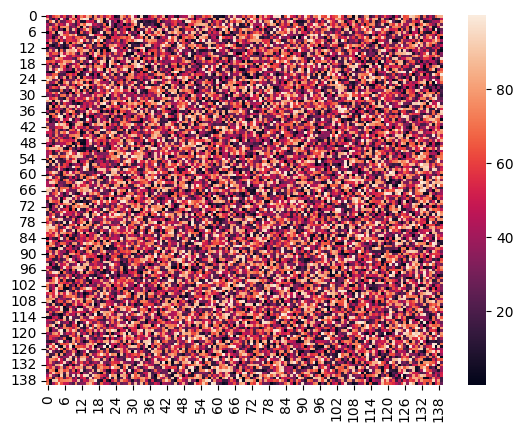

In [56]:
import seaborn as sns

sns.heatmap(np.random.rand(140, 140) * 100)

In [61]:
len(np.random.rand(4096, 1, 140, 140).shape)

4

In [70]:
from bertviz import head_view
from torch import tensor

head_view(tensor(np.random.rand(4096,1, 1, 140, 140)), tokens=[ str(i) for i in np.arange(140)])

: 

In [1]:
import pandas as pd
import numpy as np
import wandb

In [2]:
api = wandb.Api()

In [9]:
artifact = api.artifact('tft-spx/cross_validate/Predictions_2014-05-01_2014-06-01:latest')
table = artifact.get('predictions')

wandb:   1 of 1 files downloaded.  


In [13]:
df = table.get_dataframe()

In [14]:
df

,S,K,T,r,30RV,Target,MLP,LSTM,TFT,BS,Date
0,1883.36,1785.0,0.098630,0.054093,0.007357,99.550,104.687424,104.422874,99.945961,98.455231,2014-05-01 00:00:00+00:00
1,1883.36,1780.0,0.098630,0.054093,0.007357,104.255,109.122360,108.954414,104.654381,103.454964,2014-05-01 00:00:00+00:00
2,1883.36,1775.0,0.098630,0.054093,0.007357,108.850,113.542107,113.297203,109.394066,108.454697,2014-05-01 00:00:00+00:00
3,1883.36,1770.0,0.098630,0.054093,0.007357,113.695,117.949341,117.639503,114.163849,113.454431,2014-05-01 00:00:00+00:00
4,1883.36,1765.0,0.098630,0.054093,0.007357,118.350,122.279457,121.976852,118.962189,118.454164,2014-05-01 00:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...
40383,1923.39,1560.0,0.084932,0.073106,0.004777,360.100,360.847015,360.753113,368.659943,363.486858,2014-05-30 00:00:00+00:00
40384,1923.39,1570.0,0.084932,0.073106,0.004777,350.900,351.379974,350.964294,358.920563,353.487479,2014-05-30 00:00:00+00:00
40385,1923.39,1575.0,0.084932,0.073106,0.004777,345.905,346.460632,346.221161,354.042725,348.487789,2014-05-30 00:00:00+00:00
40386,1923.39,1580.0,0.084932,0.073106,0.004777,340.700,341.282104,341.348907,349.157104,343.488100,2014-05-30 00:00:00+00:00


In [17]:
np.sqrt(((df['LSTM'] - df['Target'])**2).mean())

3.481062934043578